# Step 2 - EDA, Preprocessing, Processing and Visualization (Cognify)

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

In [42]:
!pip install py7zr==0.20.8

In [43]:
'''
import py7zr

archive = py7zr.SevenZipFile('/content/drive/MyDrive/DriveDDL/combined_data.7z', mode='r')
archive.extractall(path="/content/extracted_data")
archive.close()
'''

'\nimport py7zr\n\narchive = py7zr.SevenZipFile(\'/content/drive/MyDrive/DriveDDL/combined_data.7z\', mode=\'r\')\narchive.extractall(path="/content/extracted_data") \narchive.close()\n'

In [44]:
# Load the data
df_chunks = []
for chunk in pd.read_csv('/content/extracted_data/combined_data.csv', chunksize=100000):
    df_chunks.append(chunk)
df = pd.concat(df_chunks, ignore_index=True)
print("Shape of Dataframe:", df.shape)

Shape of Dataframe: (78353418, 17)


In [45]:
# Drop 'Unnamed: 0' column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

In [46]:
df.head() # Show the head of the dataframe

Gender                           Race VeteranStatus    DisabilityStatus  \
0  Female  American Indian/Alaska Native   Not Veteran     With disability   
1  Female  American Indian/Alaska Native   Not Veteran     With disability   
2  Female  American Indian/Alaska Native   Not Veteran  Without Disability   
3  Female  American Indian/Alaska Native   Not Veteran  Without Disability   
4  Female  American Indian/Alaska Native   Not Veteran  Without Disability   

     EmploymentStatus            IndustrySector OccupancyStatus  \
0  Not in Labor Force            Non-Applicable         Unknown   
1  Not in Labor Force            Non-Applicable         Unknown   
2            Employed              Construction  Owner-occupied   
3            Employed  Education and Healthcare  Owner-occupied   
4            Employed  Education and Healthcare  Owner-occupied   

  TotalHouseholdIncome         HealthCoverage    HighestEducationLevel  Count  \
0    $100,000-$149,999  With Health Insurance        Bachelor's degree      1   
1     $200,000 or more  With Health Insurance  Some college, no degree      1   
2      $25,000-$34,999  With Health Insurance     High school graduate      1   
3      $35,000-$49,999  With Health Insurance  Some college, no degree      1   
4      $75,000-$99,999  With Health Insurance  Some college, no degree      1   

     State LeadingParty  LeadSum  LeadAvg TargetParty  TargetVotes  
0  Alabama   Republican       63     21.0  Republican   10680498.0  
1  Alabama   Republican       63     21.0  Republican   10680498.0  
2  Alabama   Republican       63     21.0  Republican   10680498.0  
3  Alabama   Republican       63     21.0  Republican   10680498.0  
4  Alabama   Republican       63     21.0  Republican   10680498.0

In [47]:
# Check if all the States are present
unique_states = df['State'].unique()
print("Unique states:", unique_states)

Unique states: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'NewHampshire' 'NewJersey' 'NewMexico' 'NewYork'
 'NorthCarolina' 'NorthDakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'RhodeIsland' 'SouthCarolina' 'SouthDakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'WestVirginia' 'Wisconsin' 'Wyoming']


# Data Cleaning and Preprocessing

In [48]:
print("\nColumns:", df.columns) # Display the columns
print("\nMissing values:")
print(df.isnull().sum()) # Display the sum of null values


Columns: Index(['Gender', 'Race', 'VeteranStatus', 'DisabilityStatus',
       'EmploymentStatus', 'IndustrySector', 'OccupancyStatus',
       'TotalHouseholdIncome', 'HealthCoverage', 'HighestEducationLevel',
       'Count', 'State', 'LeadingParty', 'LeadSum', 'LeadAvg', 'TargetParty',
       'TargetVotes'],
      dtype='object')

Missing values:
Gender                   0
Race                     0
VeteranStatus            0
DisabilityStatus         0
EmploymentStatus         0
IndustrySector           0
OccupancyStatus          0
TotalHouseholdIncome     0
HealthCoverage           0
HighestEducationLevel    0
Count                    0
State                    0
LeadingParty             0
LeadSum                  0
LeadAvg                  0
TargetParty              0
TargetVotes              0
dtype: int64


In [49]:
# Handle missing values
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

In [50]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [51]:
df.shape # Check the shape after removing the duplicates

(2937315, 17)

In [52]:
# Check again if all the States are present after removing duplicates
unique_states = df['State'].unique()
print("Unique states:", unique_states)

Unique states: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'NewHampshire' 'NewJersey' 'NewMexico' 'NewYork'
 'NorthCarolina' 'NorthDakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'RhodeIsland' 'SouthCarolina' 'SouthDakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'WestVirginia' 'Wisconsin' 'Wyoming']


In [53]:
# Handle TotalHouseholdIncome
df['TotalHouseholdIncome'] = df['TotalHouseholdIncome'].str.replace('[$,]', '', regex=True)
df[['TotalHouseholdIncomeMin', 'TotalHouseholdIncomeMax']] = df['TotalHouseholdIncome'].str.split('-', expand=True)
df['TotalHouseholdIncomeMin'] = pd.to_numeric(df['TotalHouseholdIncomeMin'], errors='coerce')
df['TotalHouseholdIncomeMax'] = pd.to_numeric(df['TotalHouseholdIncomeMax'], errors='coerce')

# Drop the original TotalHouseholdIncome column
df = df.drop('TotalHouseholdIncome', axis=1)

In [54]:
print(df.describe()) # Show descriptive statistics

              Count       LeadSum       LeadAvg   TargetVotes  \
count  2.937315e+06  2.937315e+06  2.937315e+06  2.937315e+06   
mean   1.968758e+00  2.447862e+02  1.261792e+01  1.689259e+07   
std    4.608817e+00  2.338692e+02  7.260133e+00  3.401276e+07   
min    1.000000e+00  2.000000e+00  2.000000e+00  2.440010e+05   
25%    1.000000e+00  6.300000e+01  6.454545e+00  4.319677e+06   
50%    1.000000e+00  1.330000e+02  1.200000e+01  8.898921e+06   
75%    2.000000e+00  4.060000e+02  2.033333e+01  1.407662e+07   
max    6.100000e+02  7.730000e+02  2.940000e+01  1.773909e+08   

       TotalHouseholdIncomeMin  TotalHouseholdIncomeMax  
count             2.379035e+06             2.379035e+06  
mean              5.915032e+04             8.337551e+04  
std               4.266638e+04             5.730970e+04  
min               1.000000e+04             1.499900e+04  
25%               2.500000e+04             3.499900e+04  
50%               5.000000e+04             7.499900e+04  
75%     

In [55]:
# Handle outliers
'''
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_columns = ['Count', 'LeadSum', 'LeadAvg', 'TargetVotes', 'TotalHouseholdIncomeMin', 'TotalHouseholdIncomeMax']
for col in numeric_columns:
    df = remove_outliers(df, col)
'''

"\ndef remove_outliers(df, column):\n    Q1 = df[column].quantile(0.25)\n    Q3 = df[column].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]\n\nnumeric_columns = ['Count', 'LeadSum', 'LeadAvg', 'TargetVotes', 'TotalHouseholdIncomeMin', 'TotalHouseholdIncomeMax']\nfor col in numeric_columns:\n    df = remove_outliers(df, col)\n"

In [56]:
# Get the numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

In [57]:
# Standardize text data

# Identify all object (string) columns in the DataFrame
text_columns = df.select_dtypes(include=['object']).columns

# Standardize text data for all identified columns
for col in text_columns:
    df[col] = df[col].astype(str).str.lower().str.strip()

print("Standardized text columns:", text_columns.tolist())

Standardized text columns: ['Gender', 'Race', 'VeteranStatus', 'DisabilityStatus', 'EmploymentStatus', 'IndustrySector', 'OccupancyStatus', 'HealthCoverage', 'HighestEducationLevel', 'State', 'LeadingParty', 'TargetParty']


# Exploratory Data Analysis

In [58]:
# Distinguishing Numerical and Categorical Columns
numeric_cols = ['Count', 'LeadSum', 'LeadAvg', 'TargetVotes', 'TotalHouseholdIncomeMin', 'TotalHouseholdIncomeMax']
categorical_cols = ['Gender', 'Race', 'VeteranStatus', 'DisabilityStatus', 'EmploymentStatus', 'IndustrySector', 'State', 'LeadingParty']

### Univariate Analysis

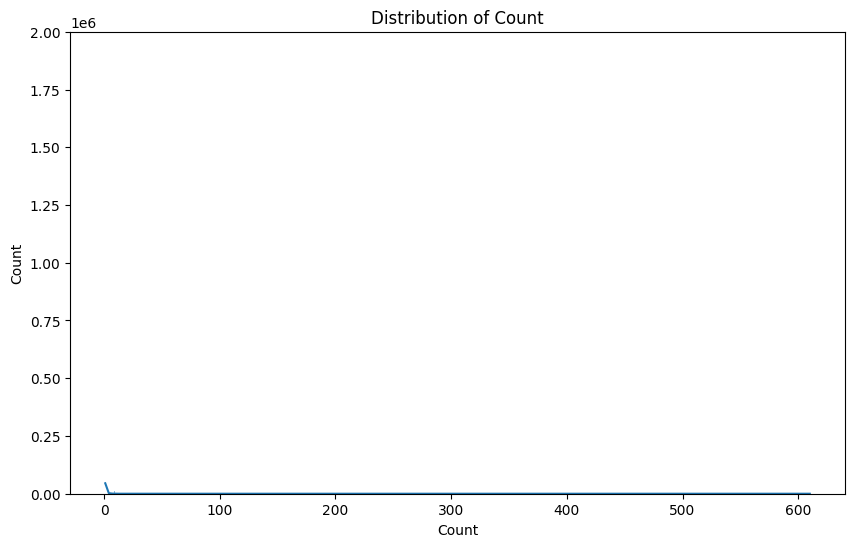

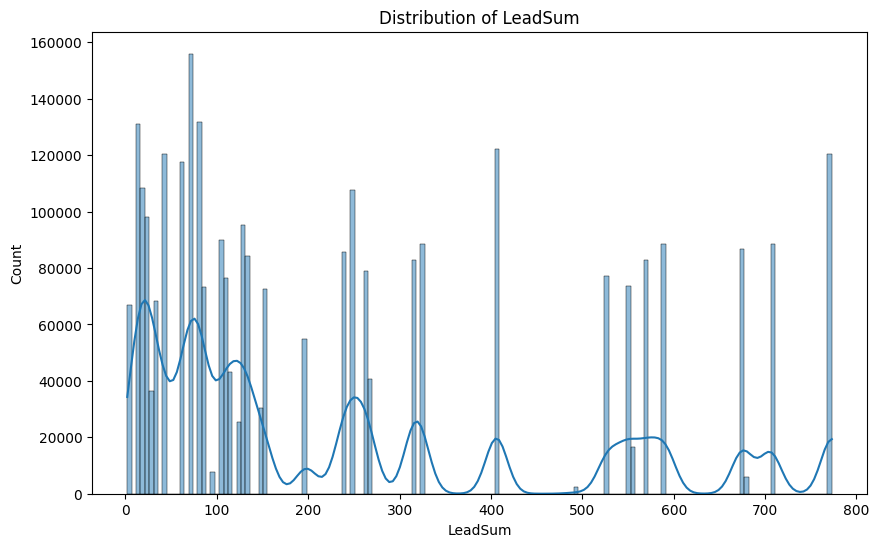

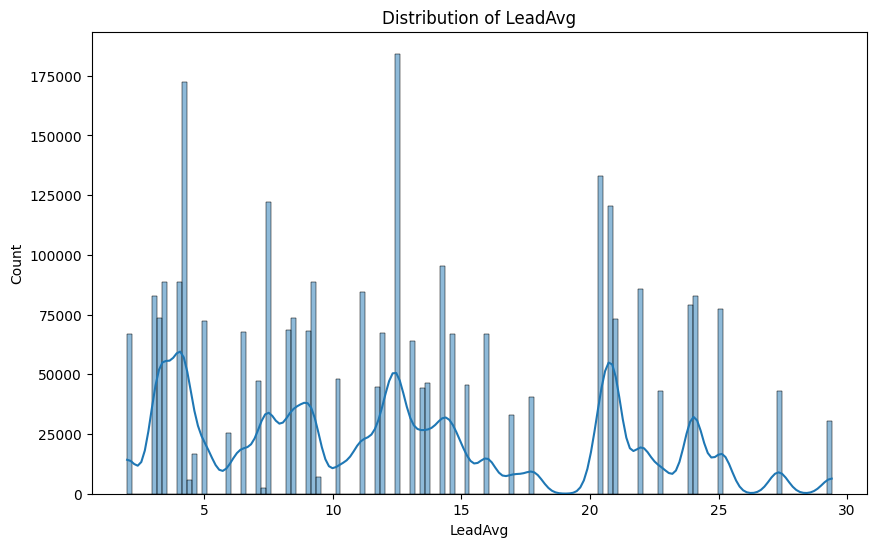

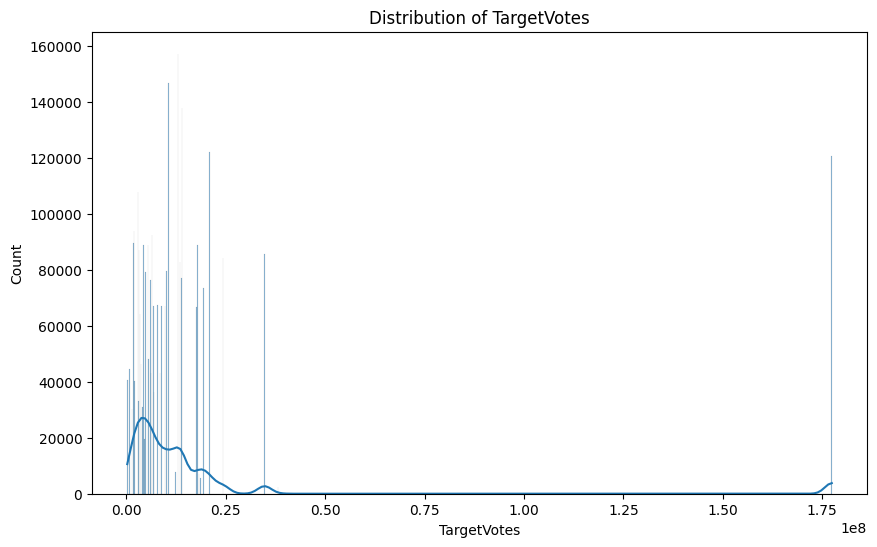

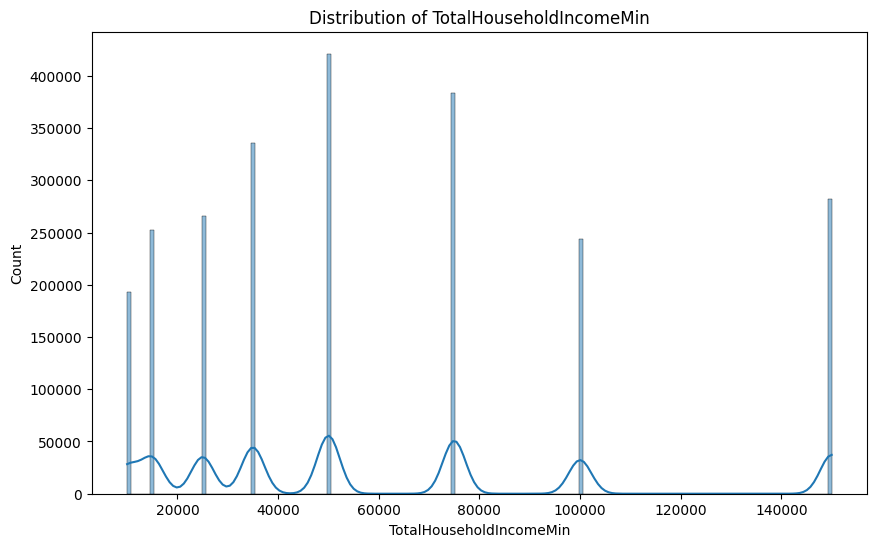

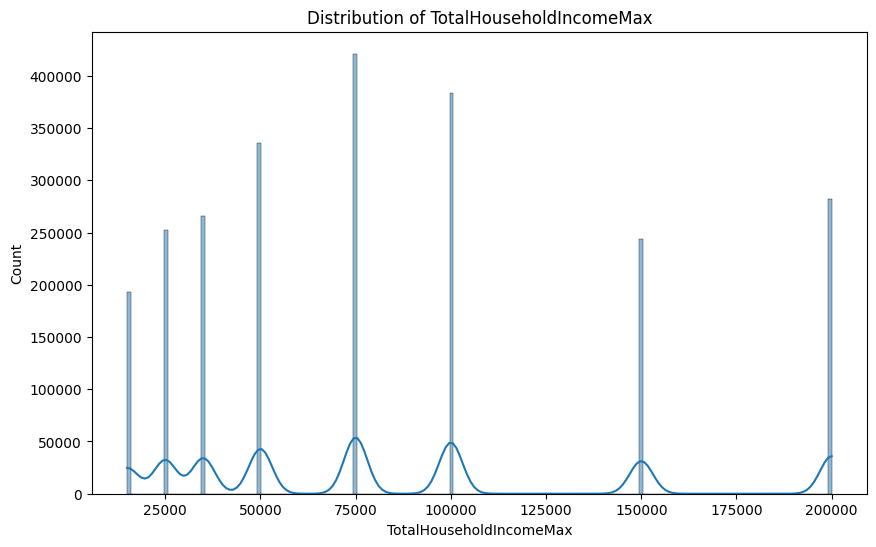

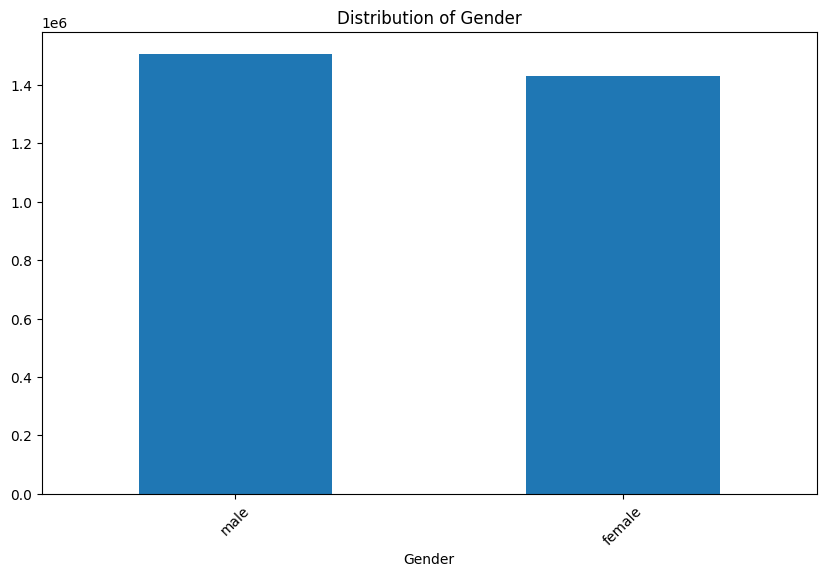

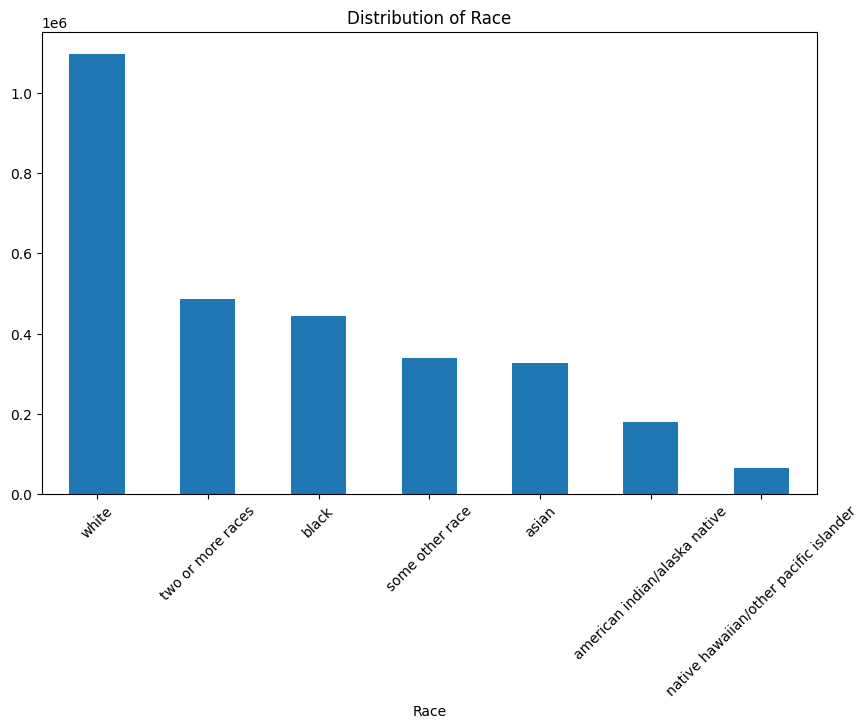

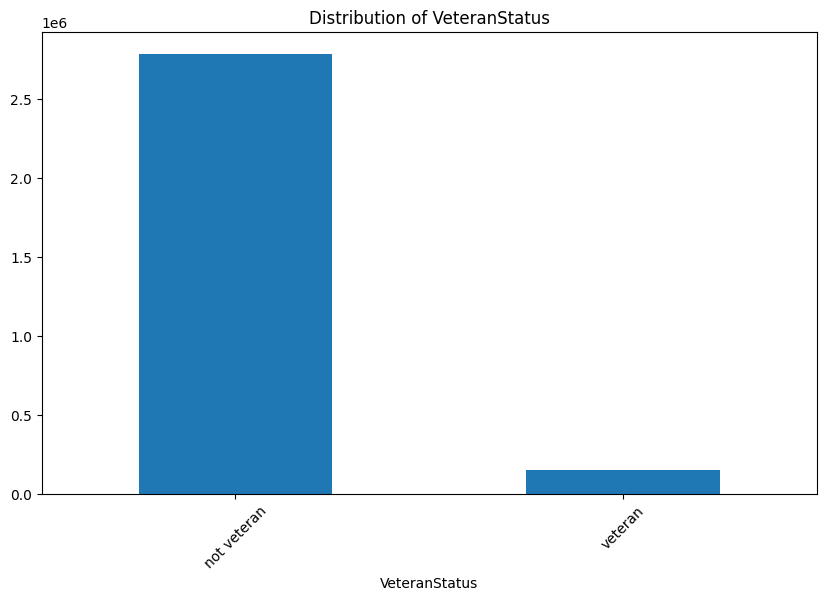

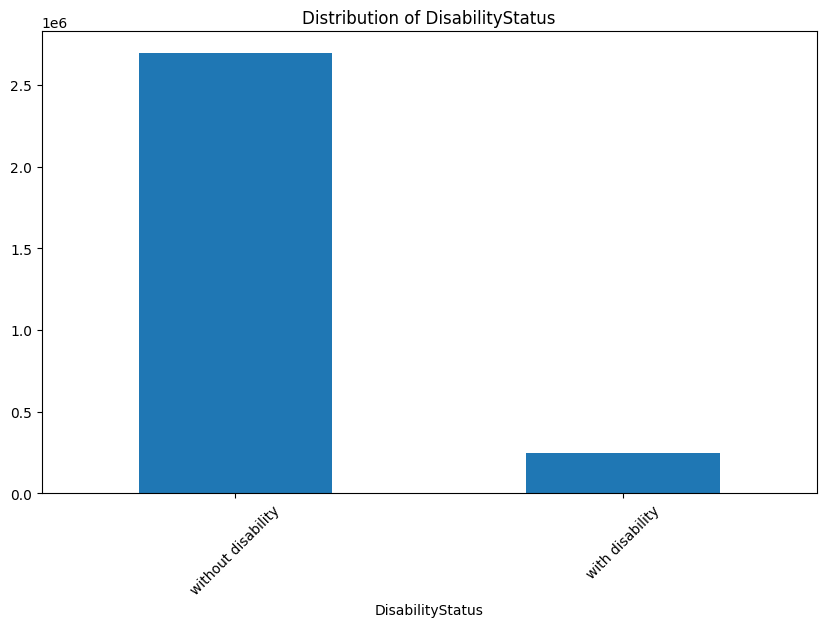

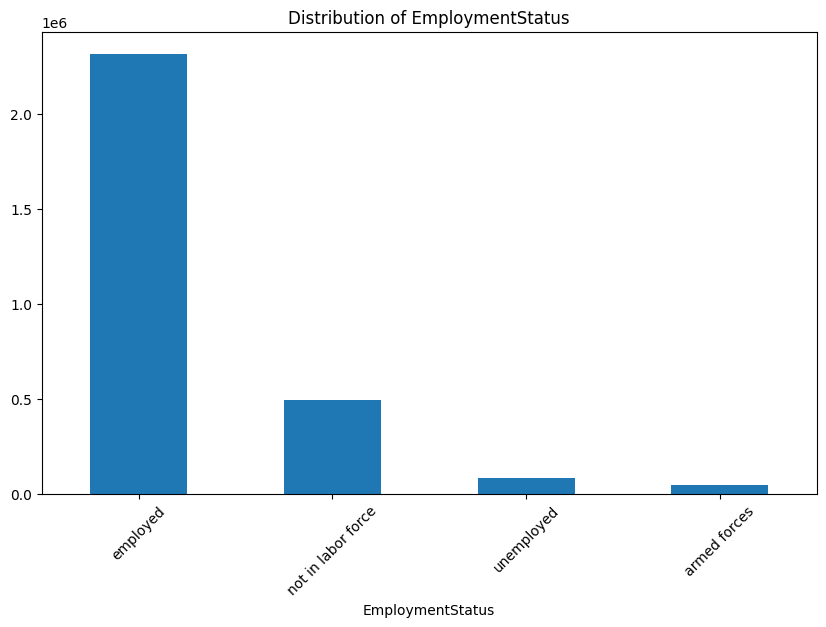

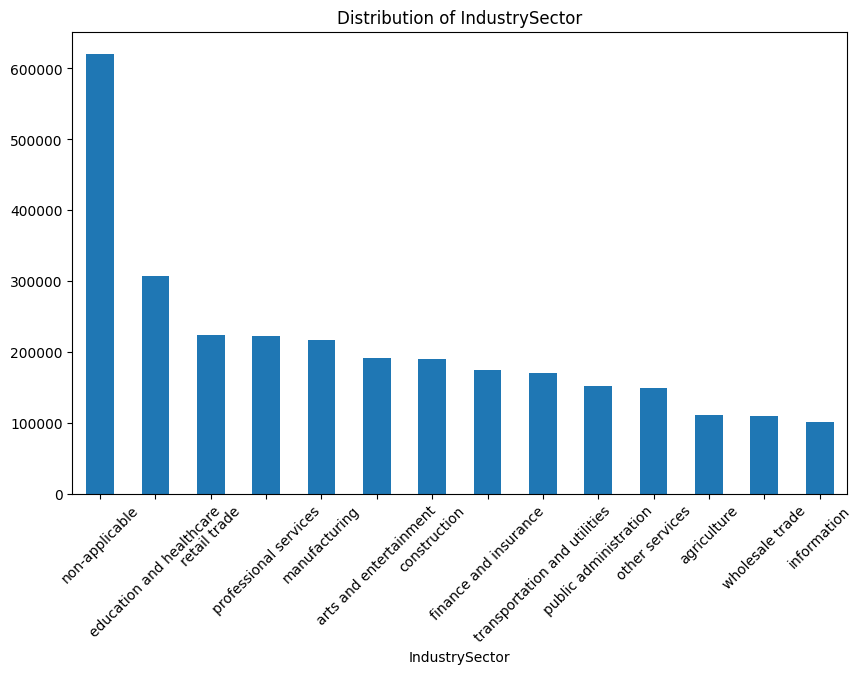

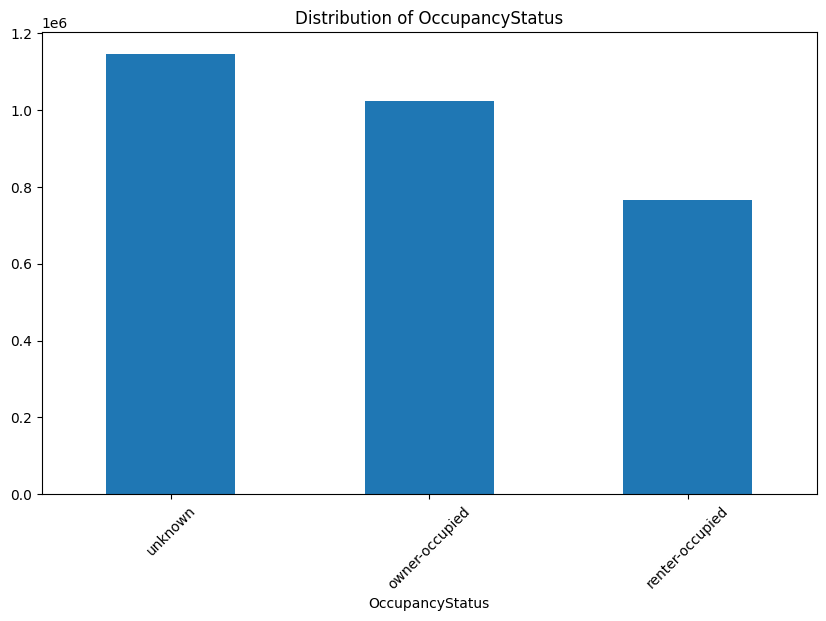

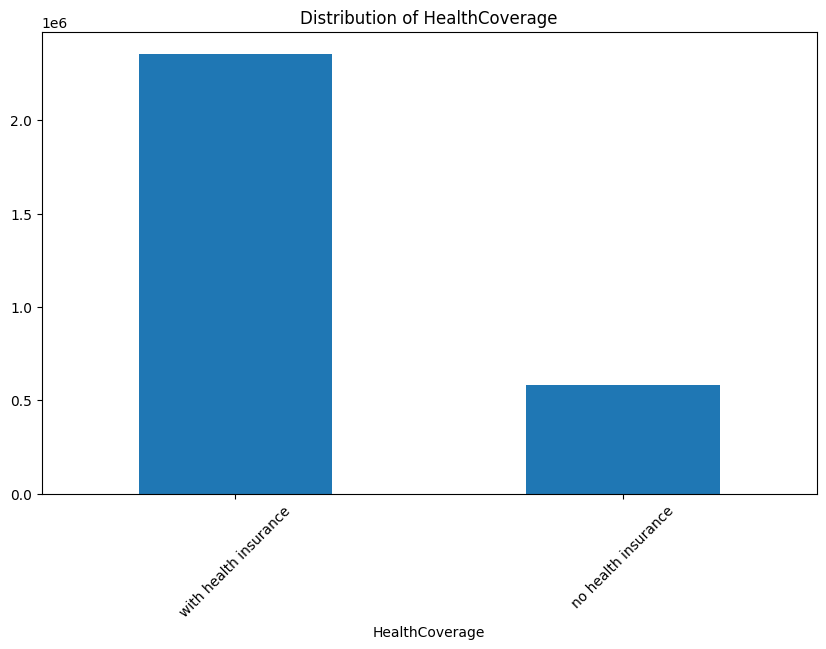

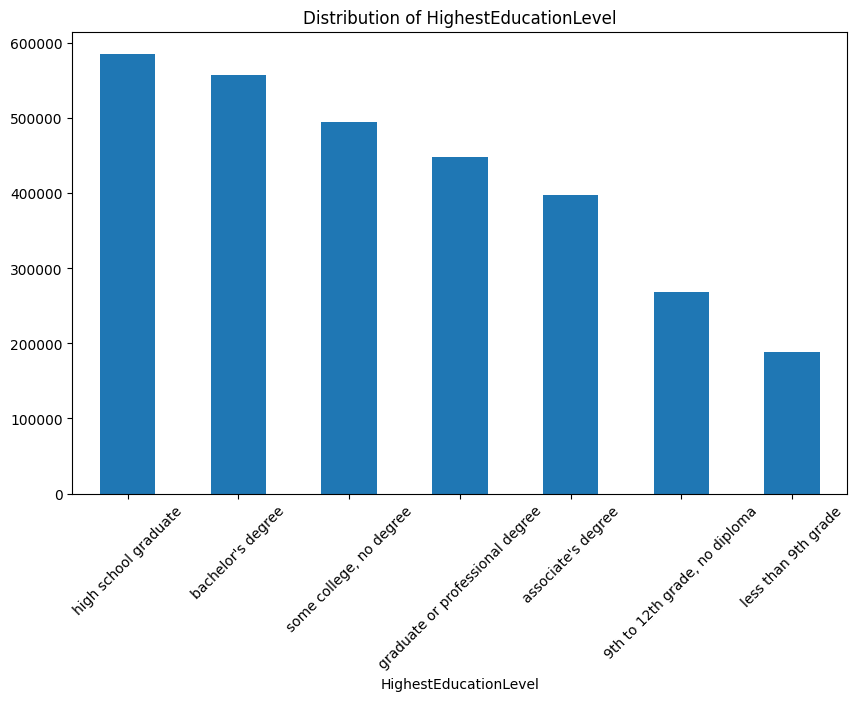

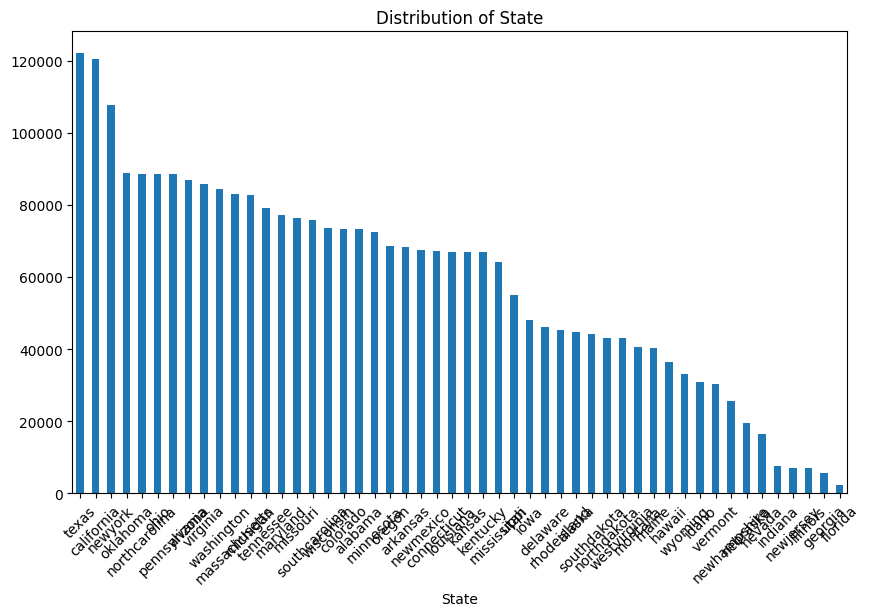

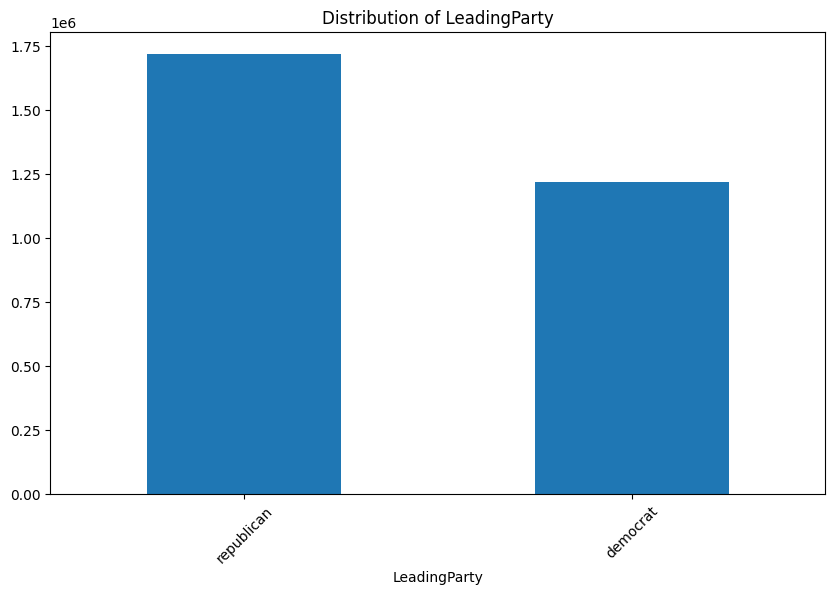

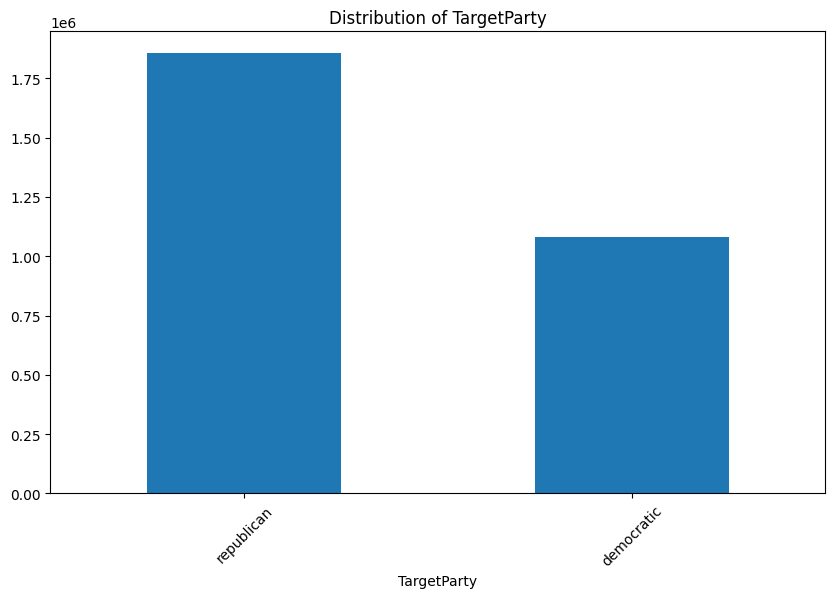

In [59]:
# Analyze distribution of individual variables
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

for col in text_columns:
    plt.figure(figsize=(10, 6))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

### Bivariate Analysis

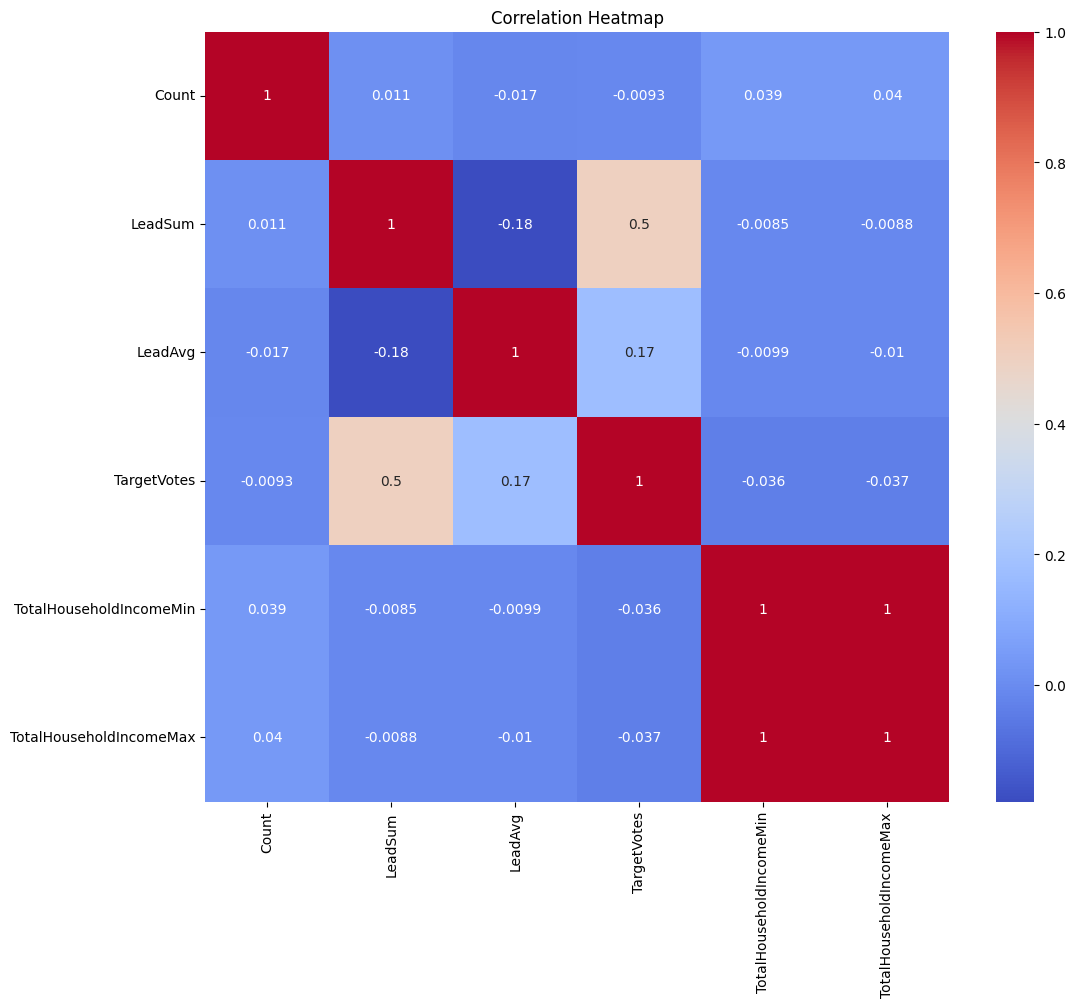

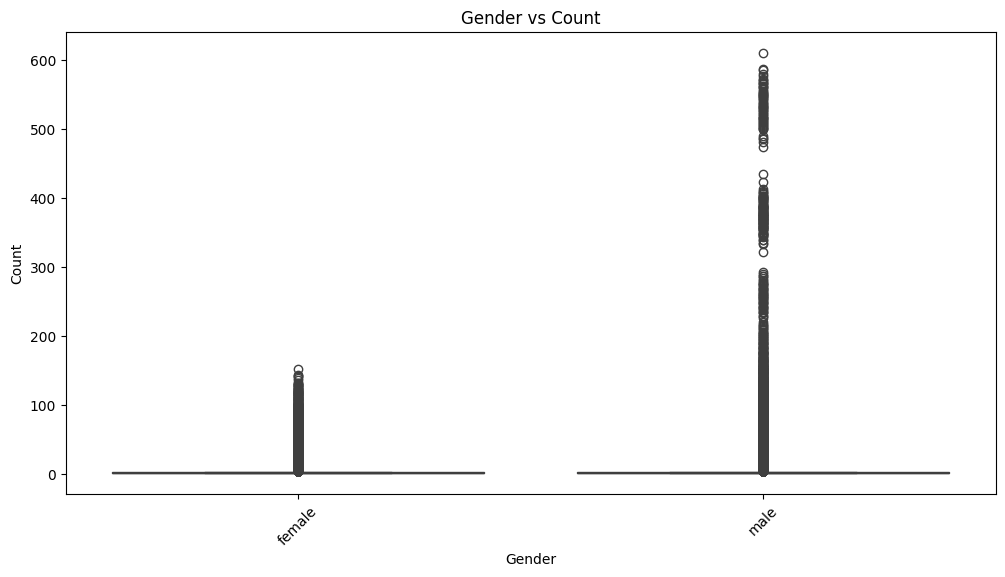

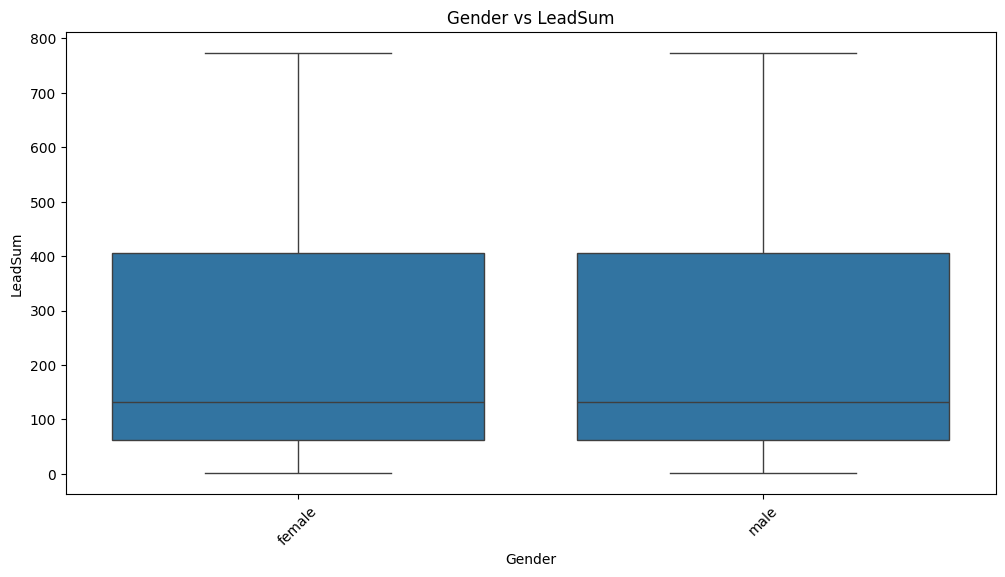

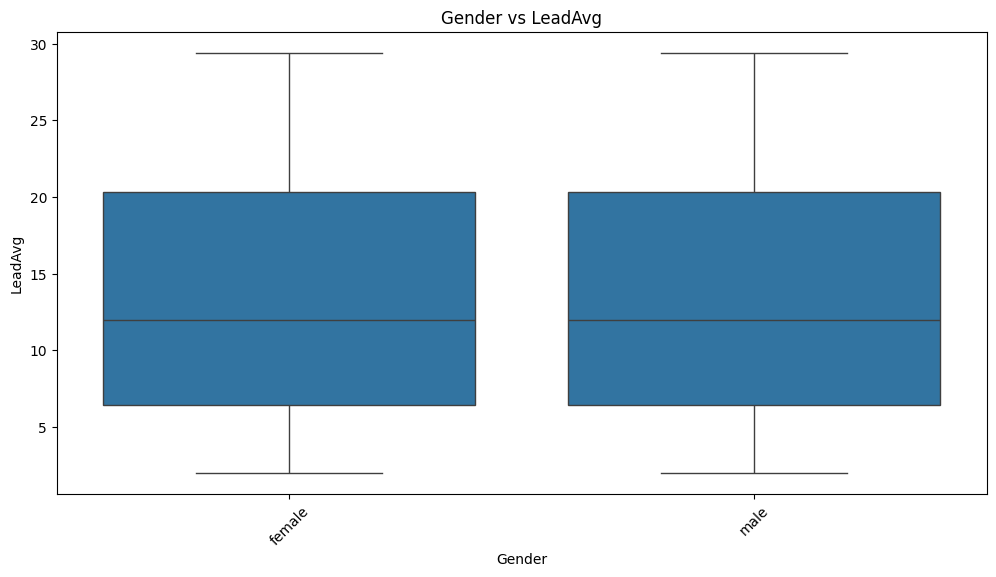

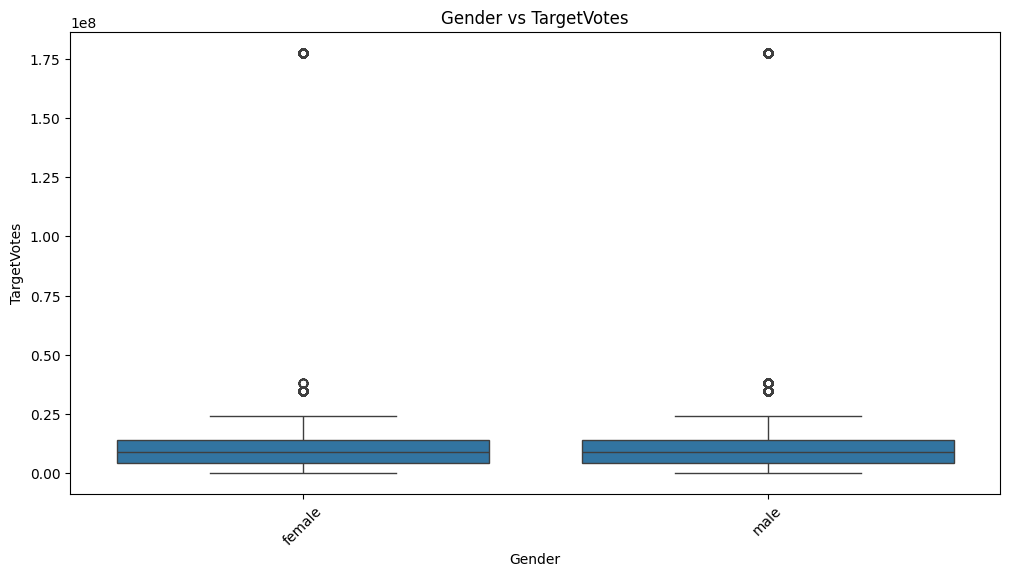

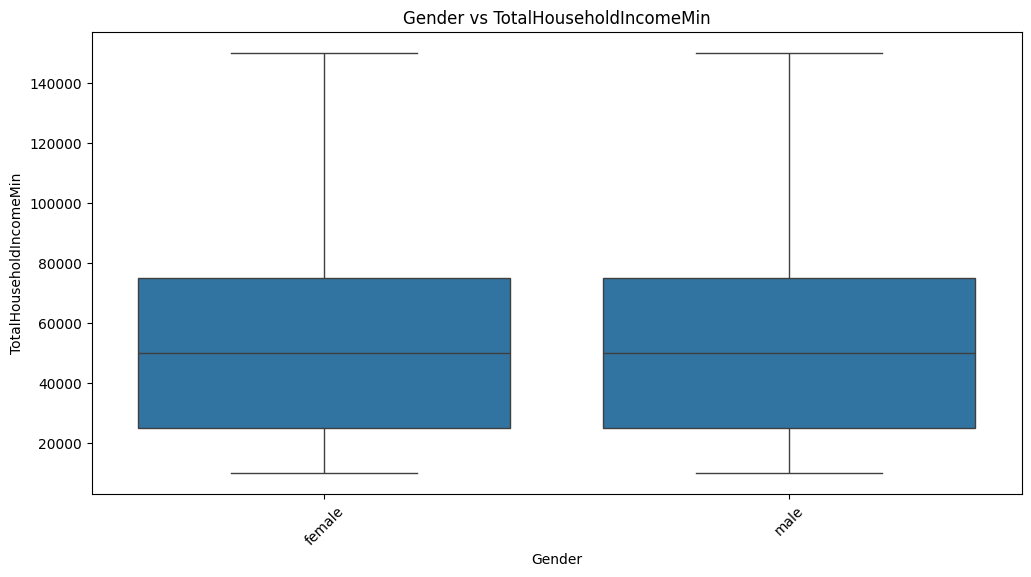

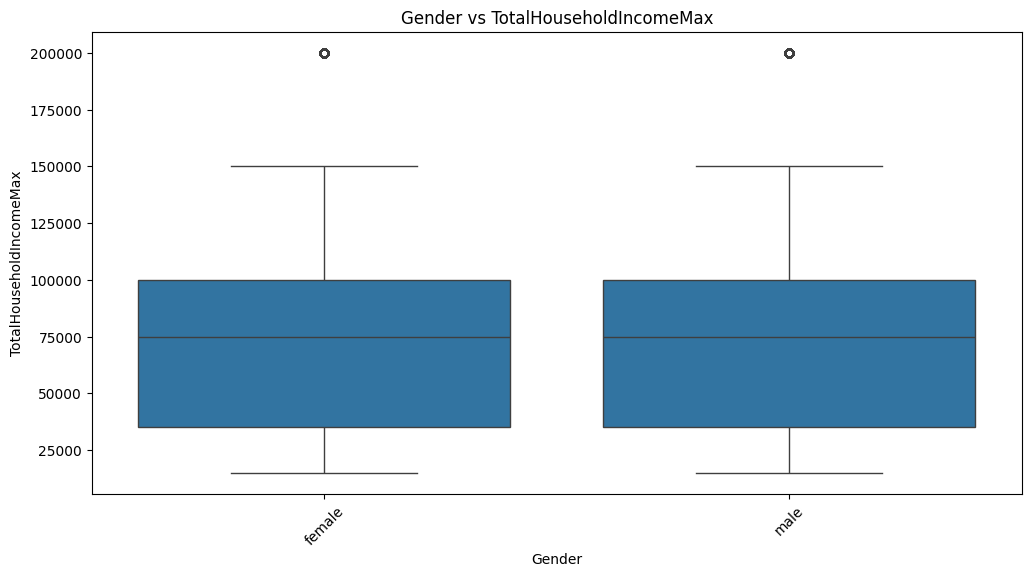

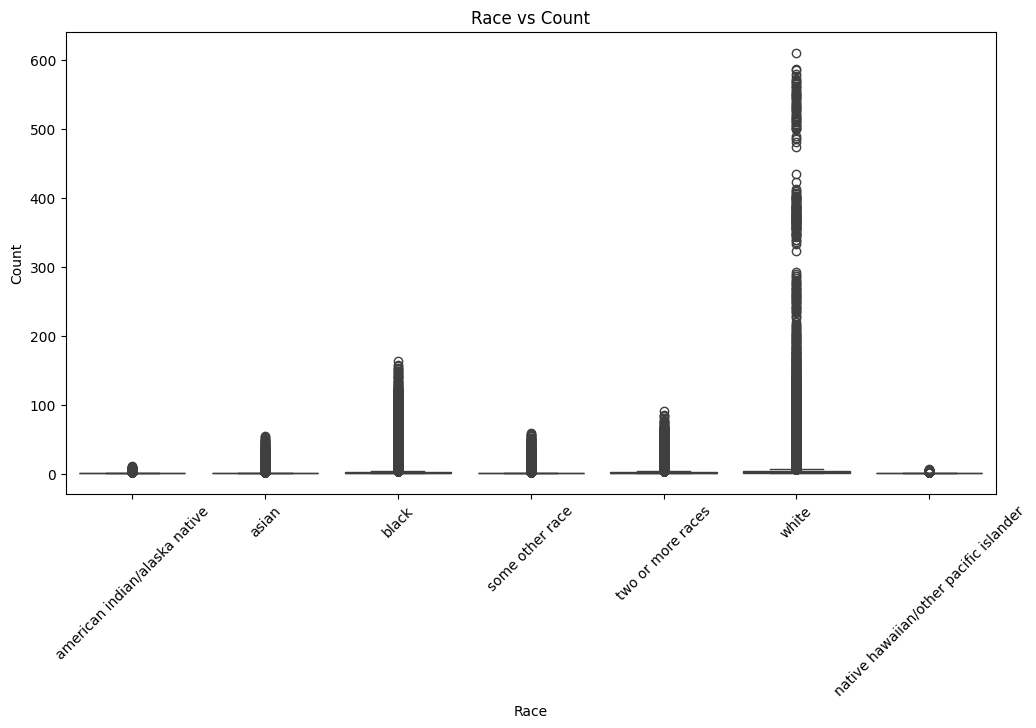

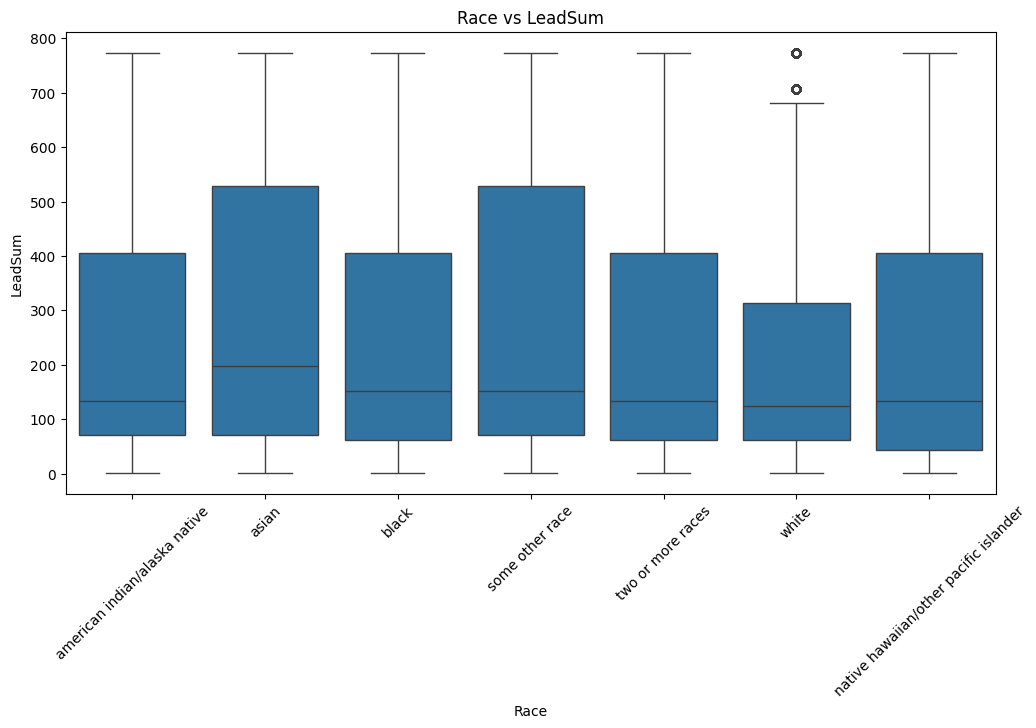

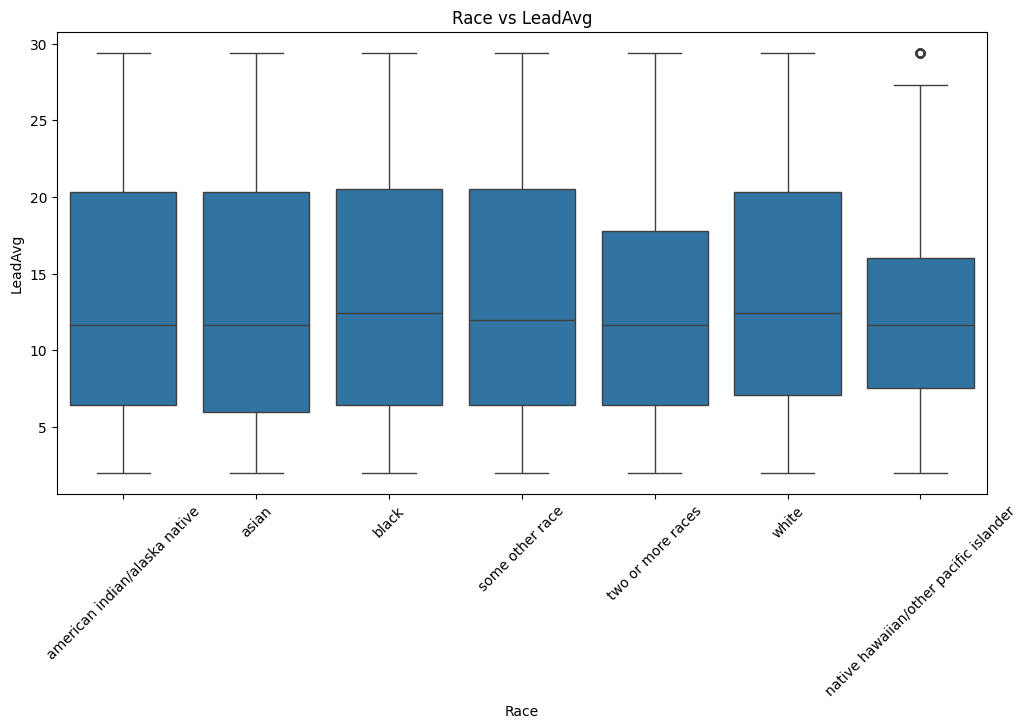

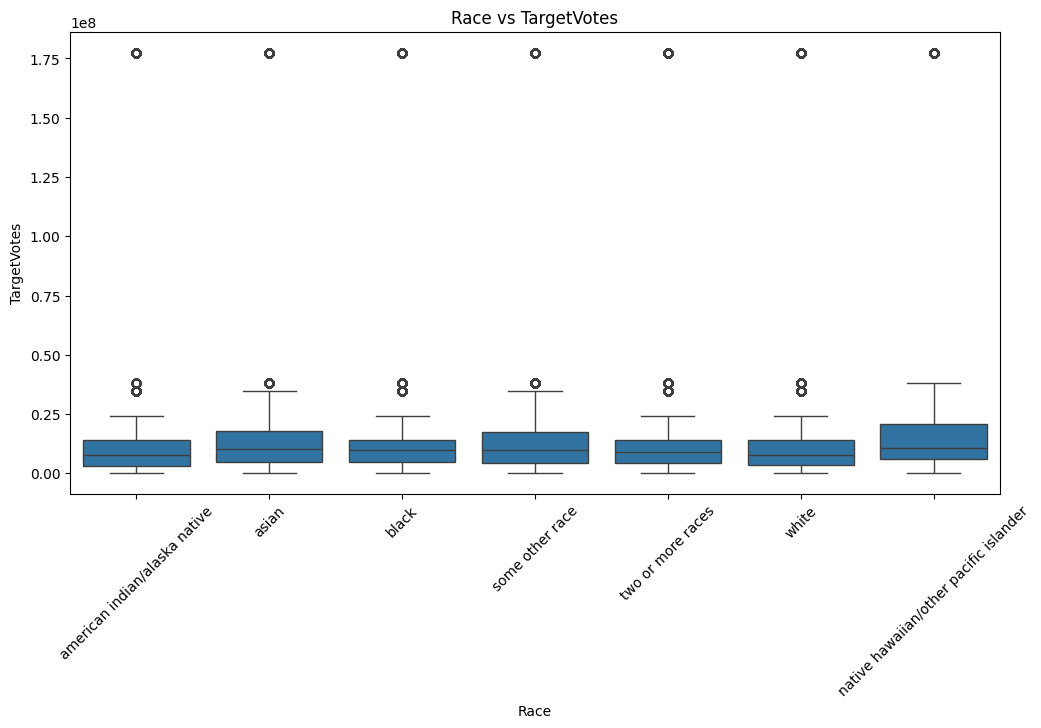

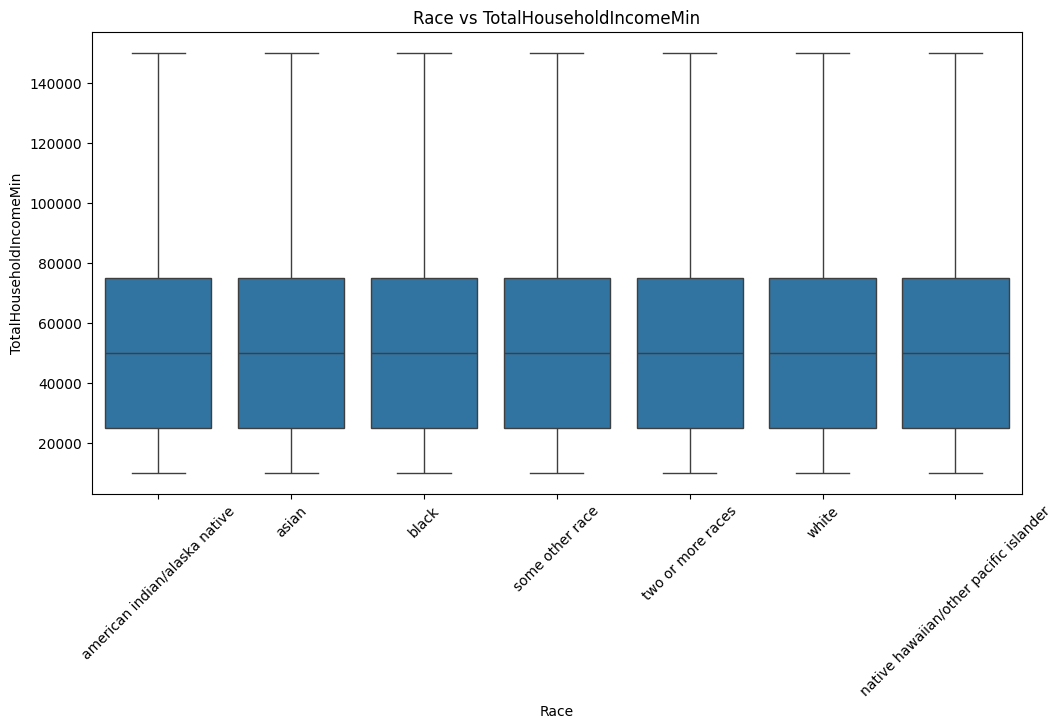

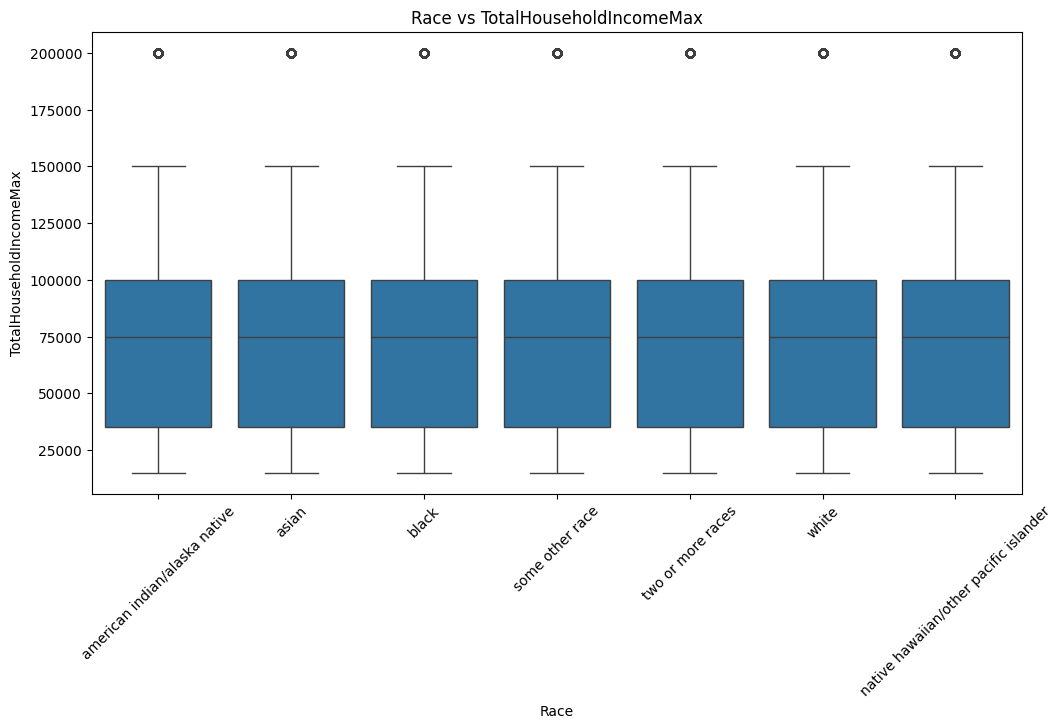

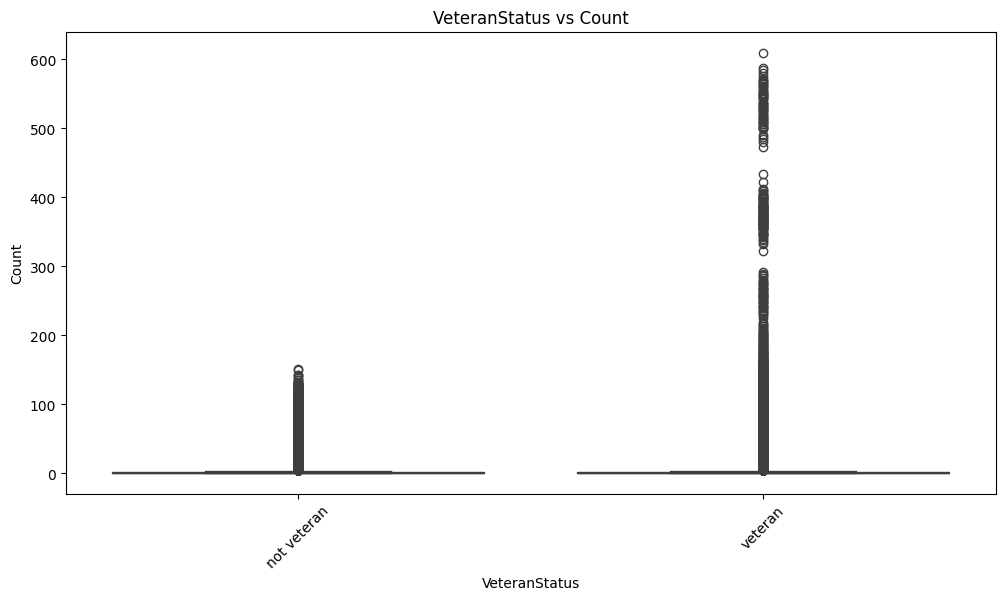

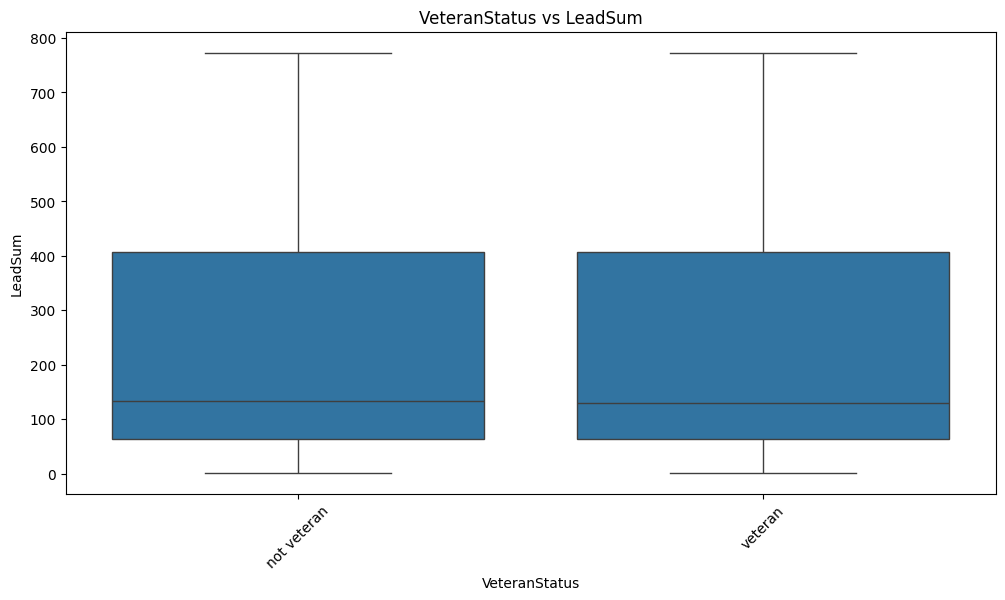

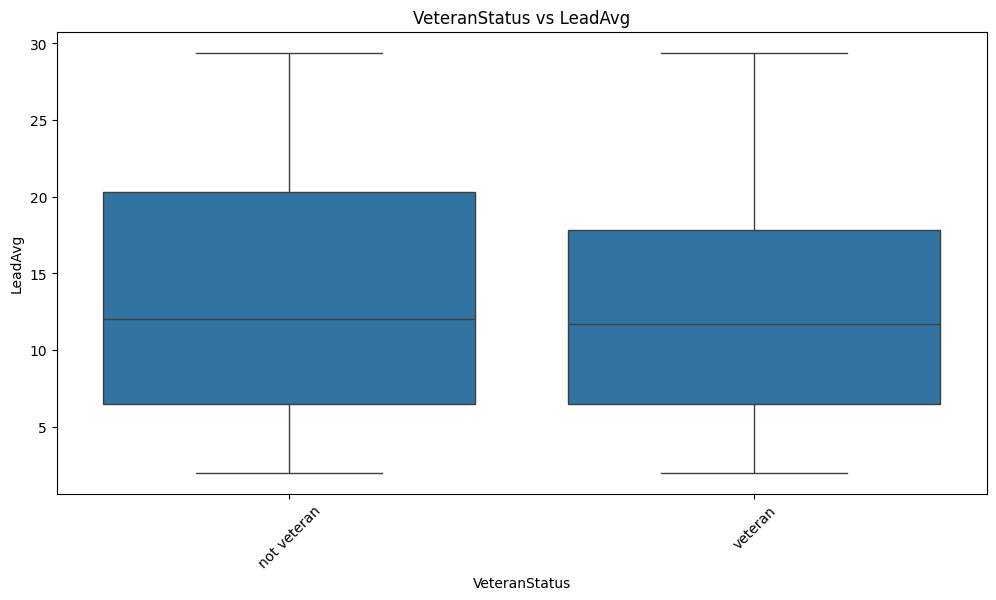

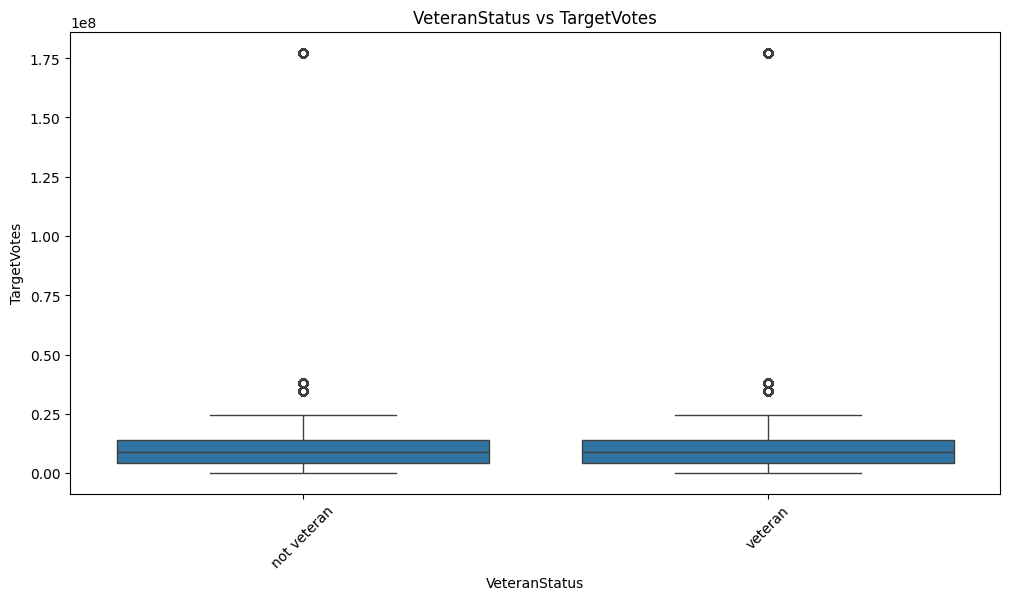

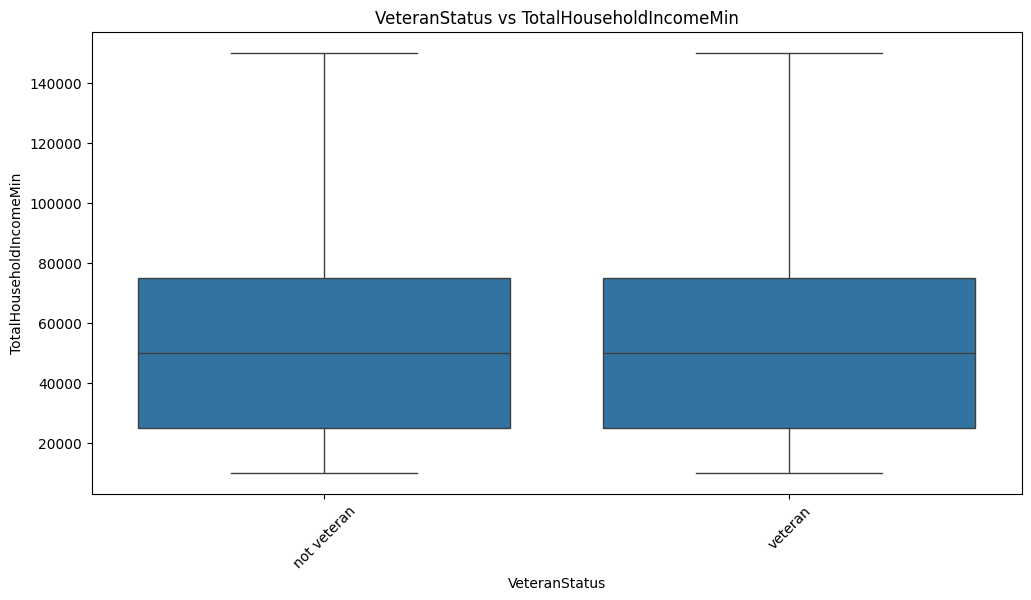

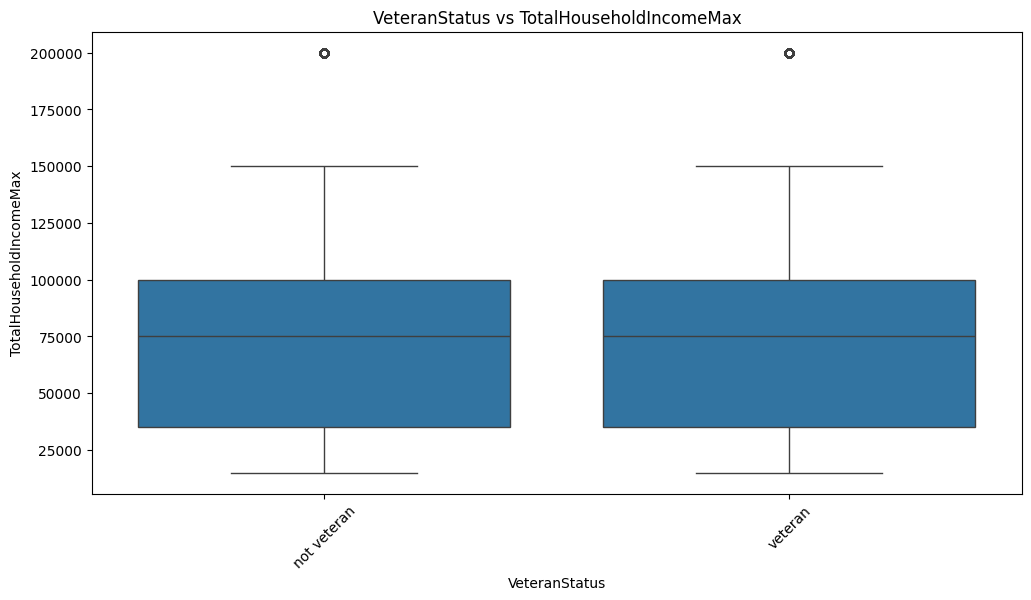

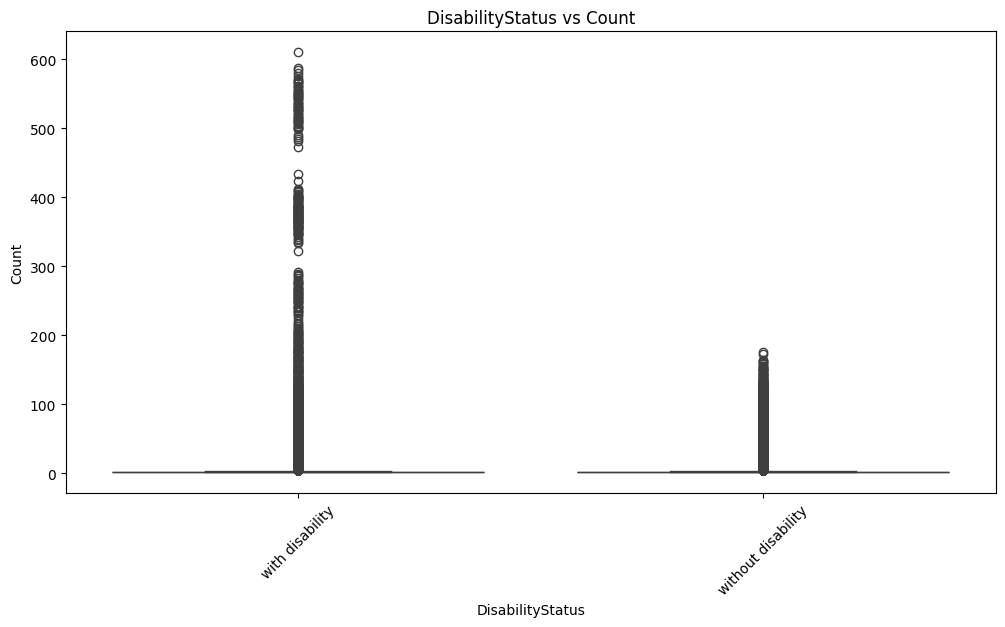

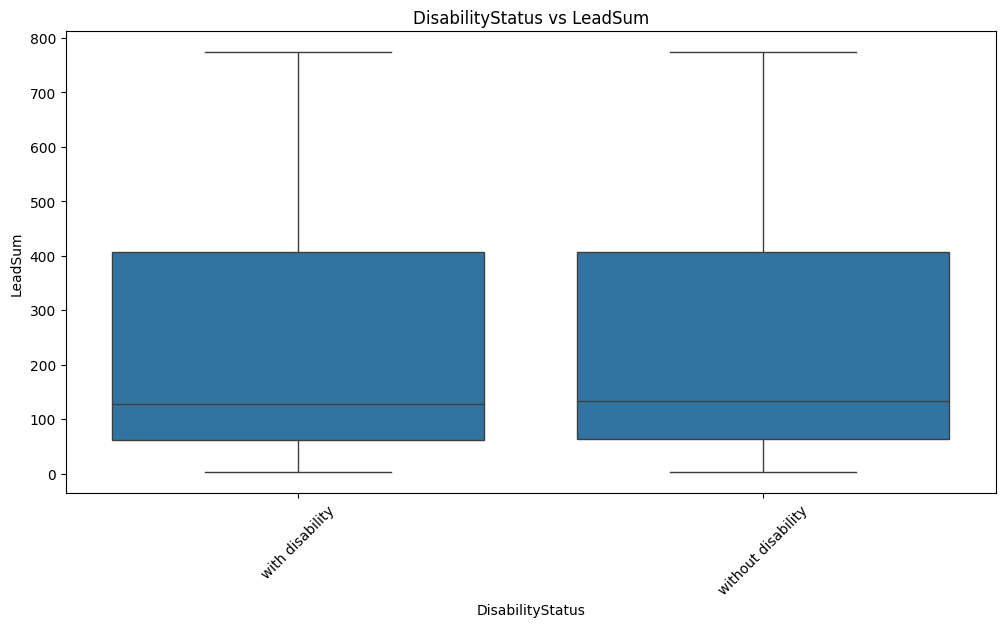

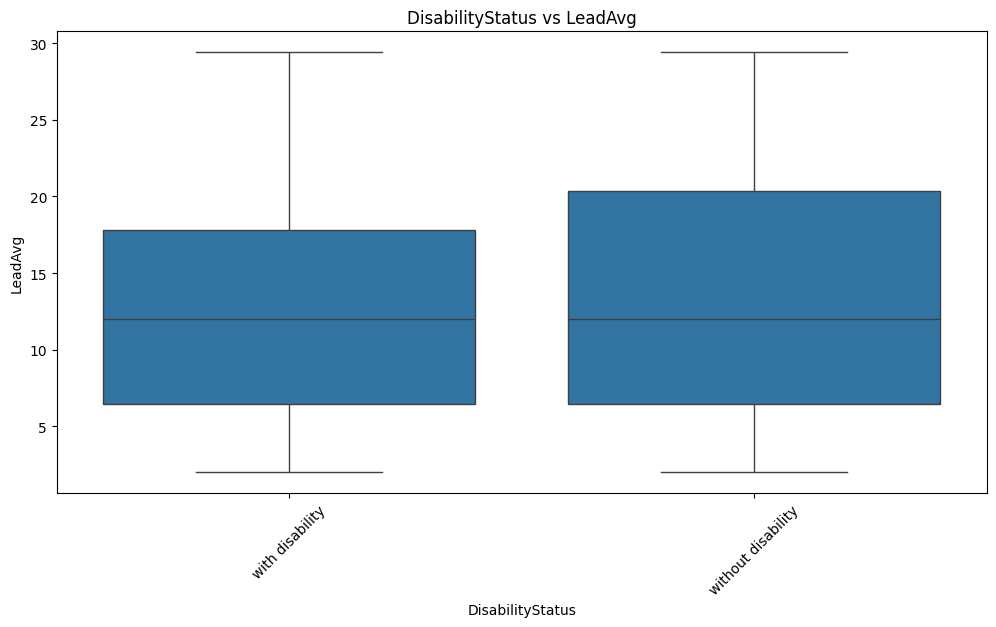

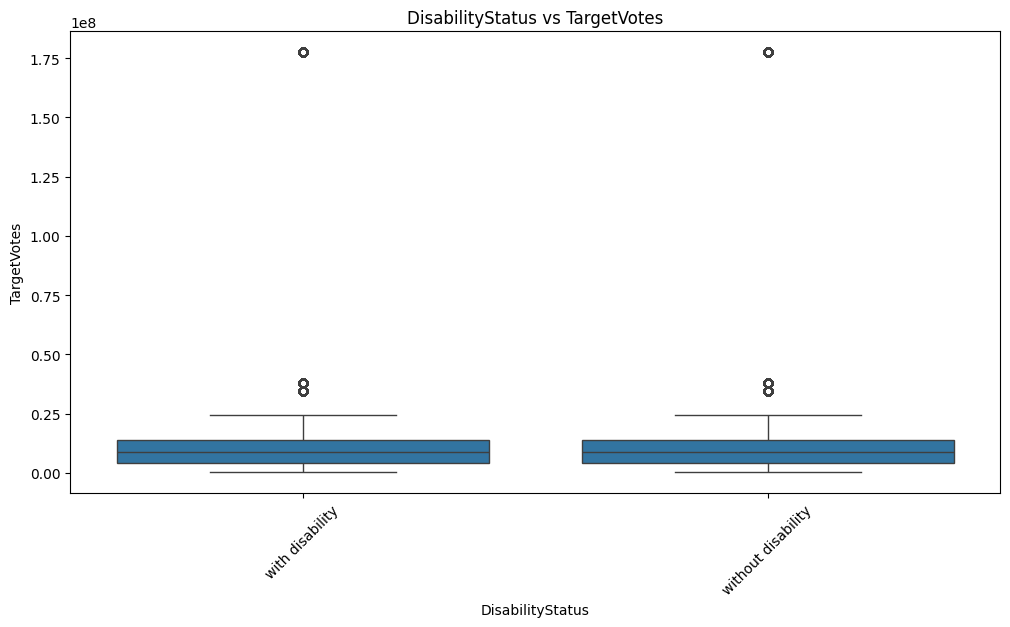

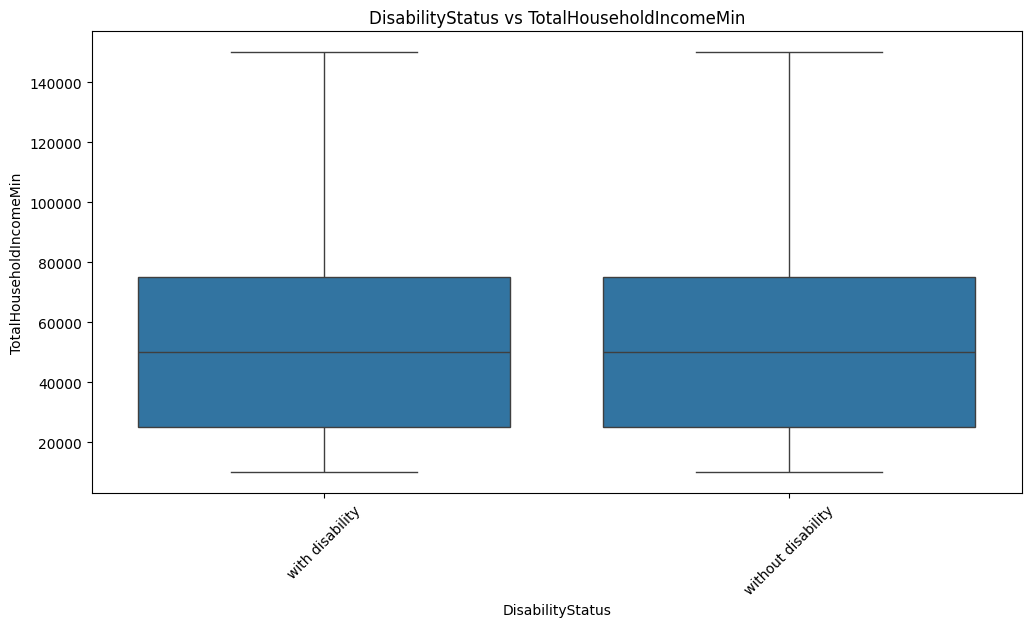

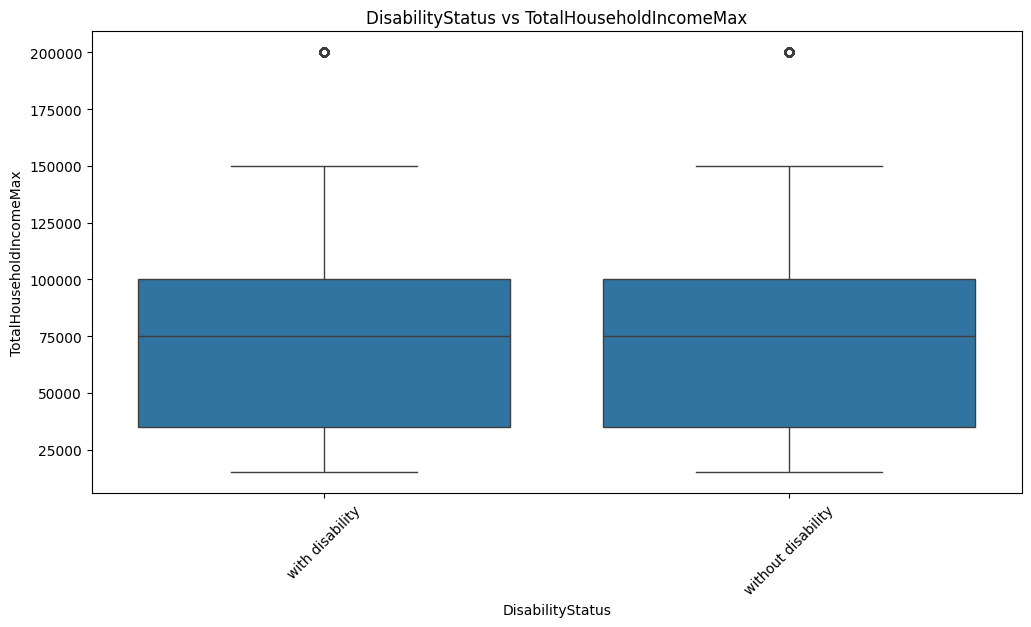

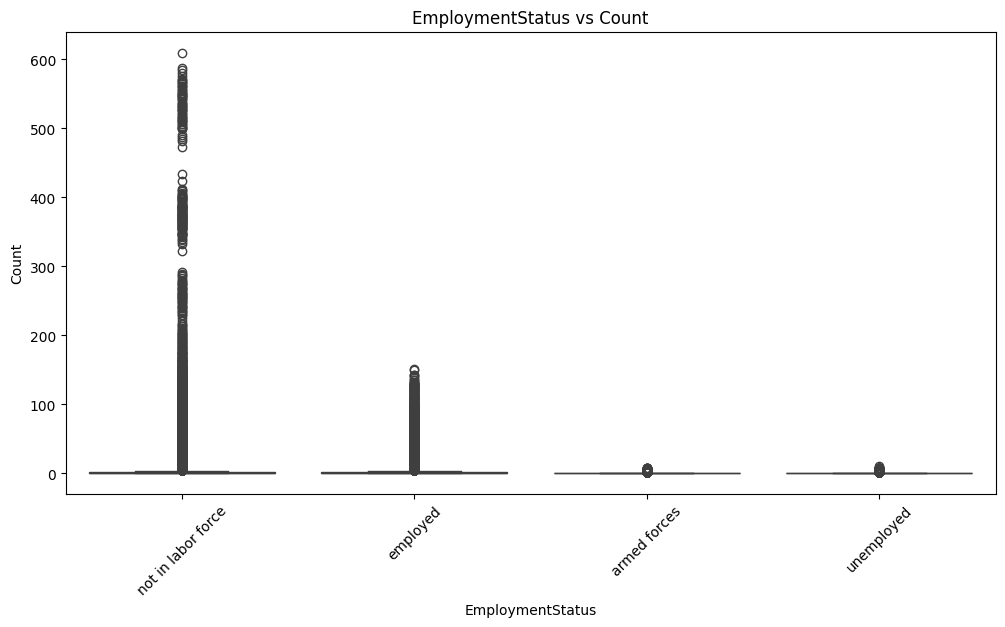

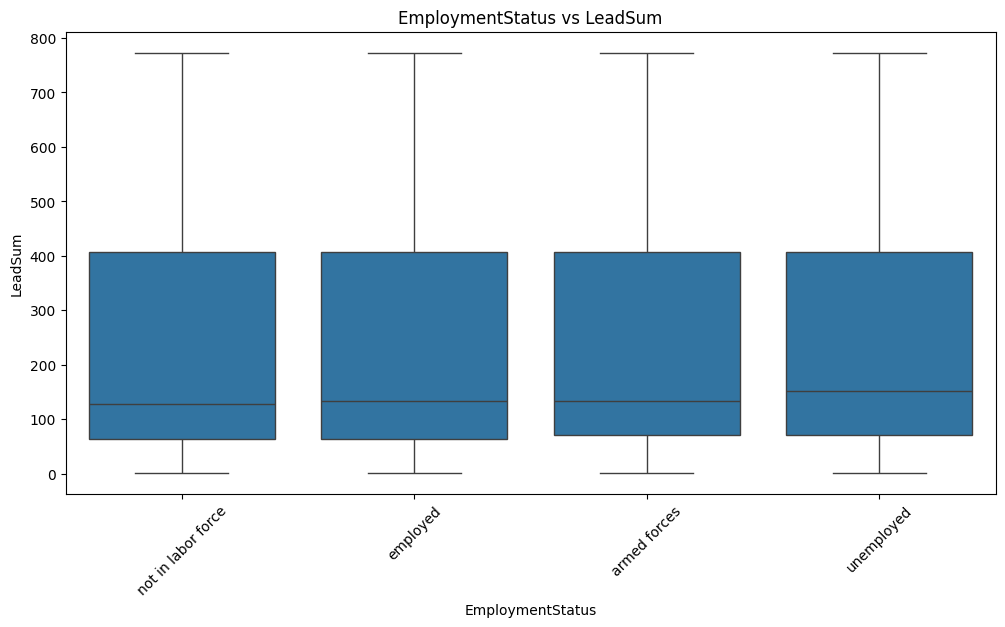

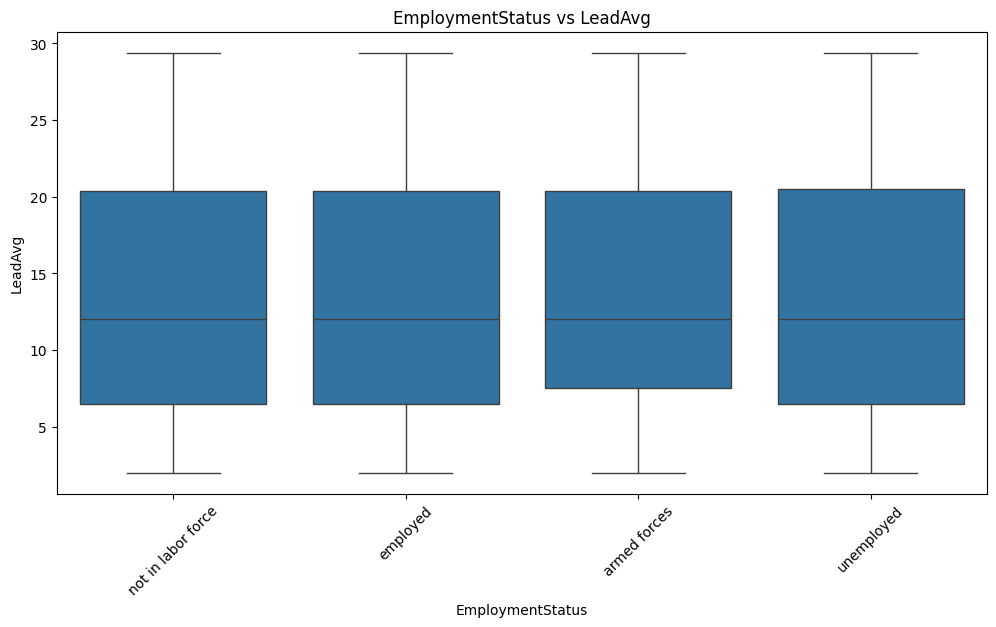

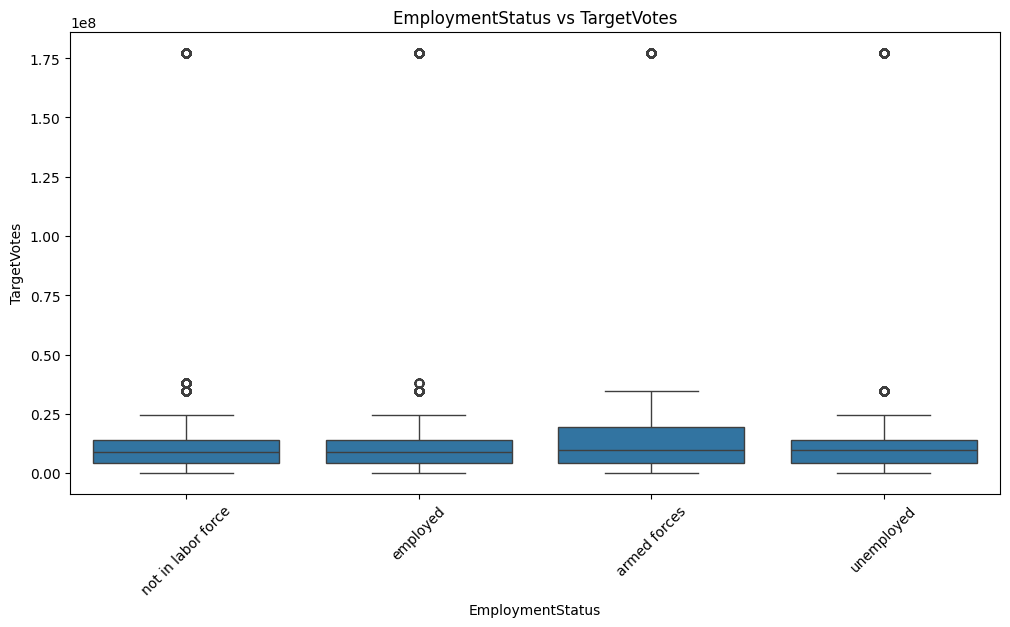

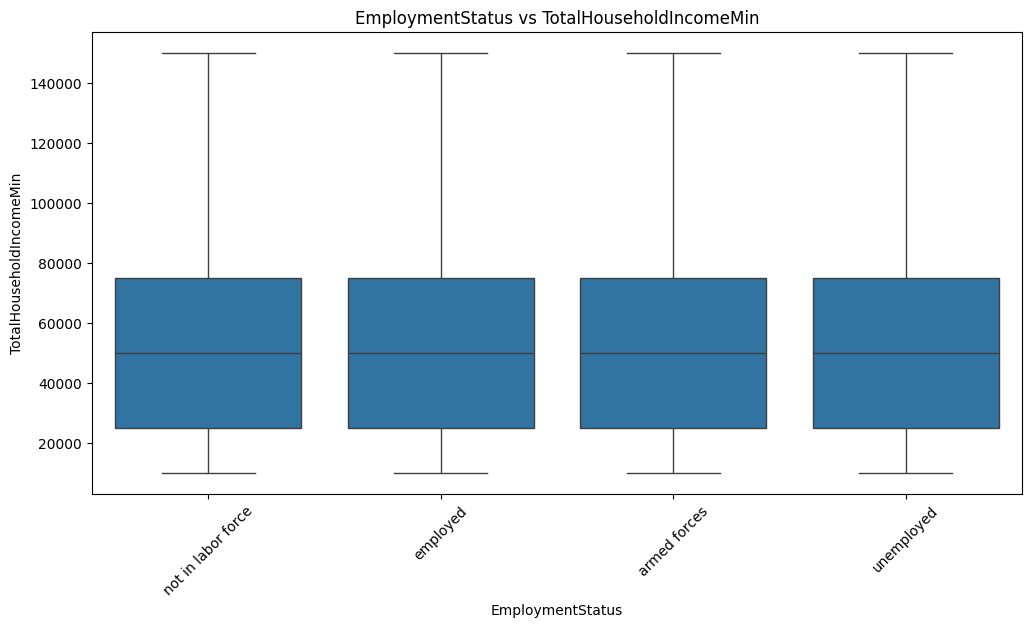

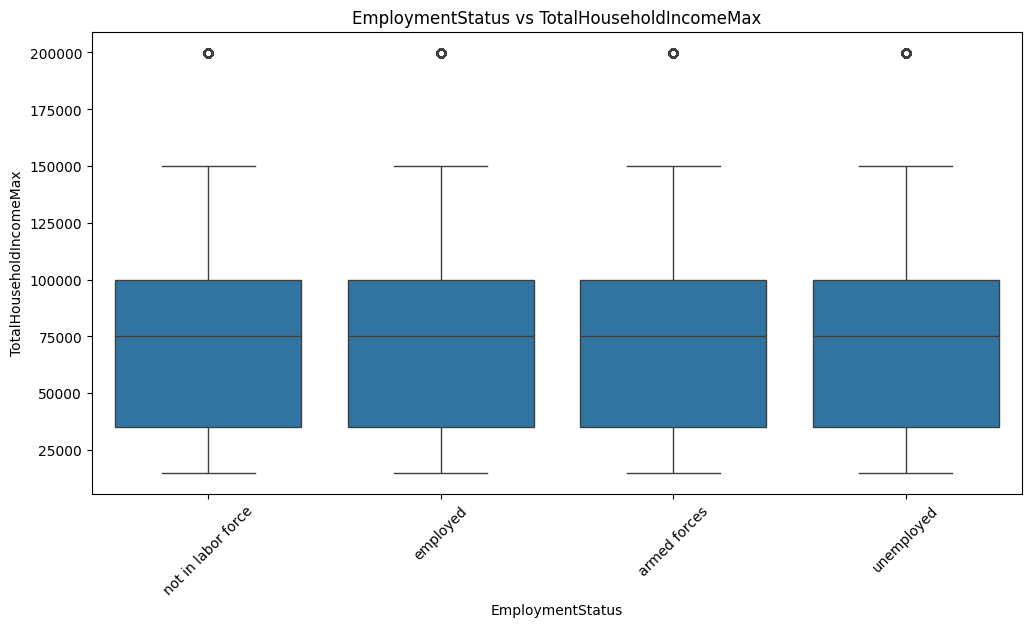

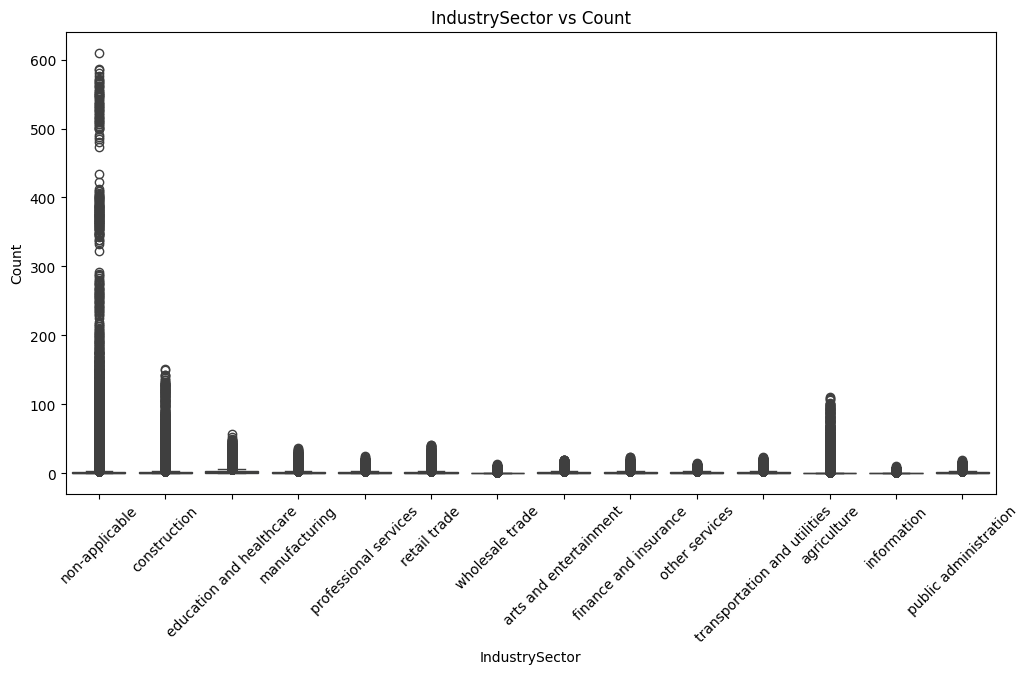

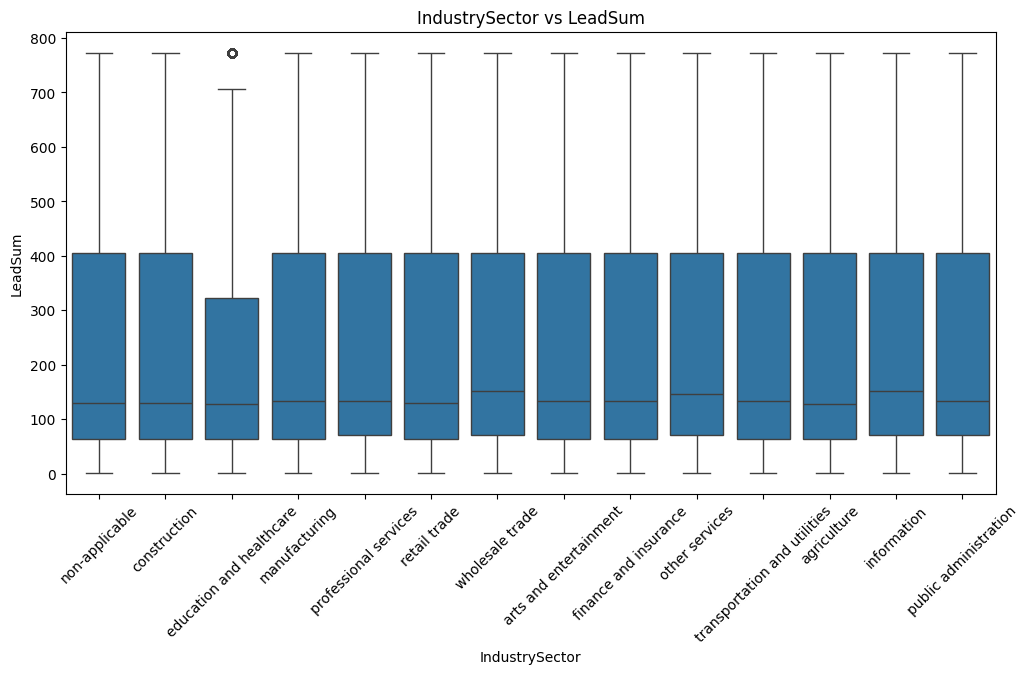

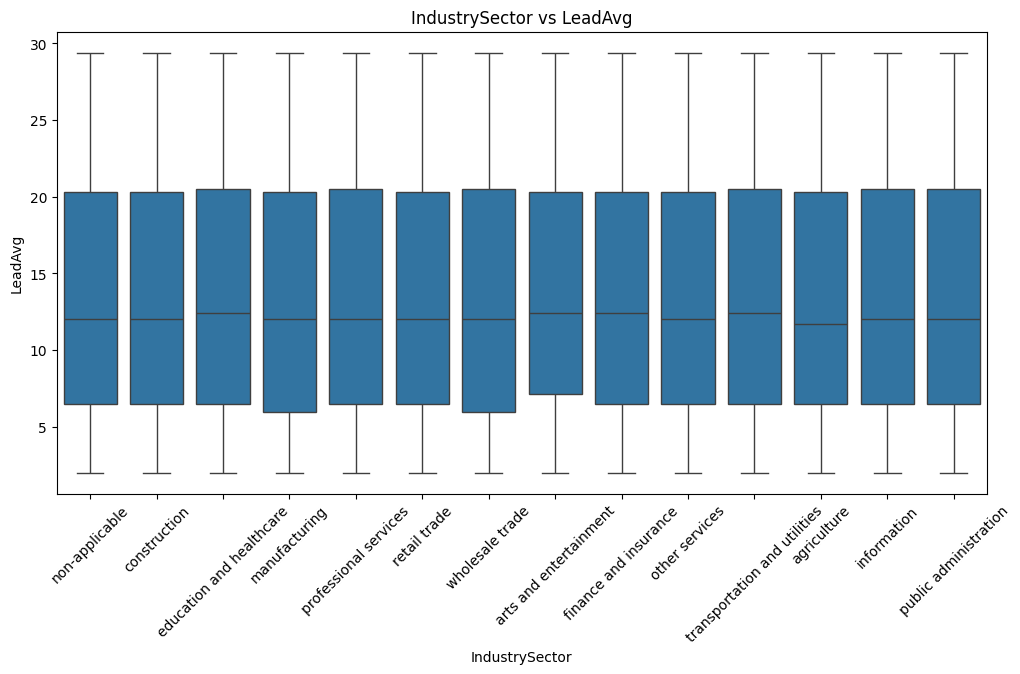

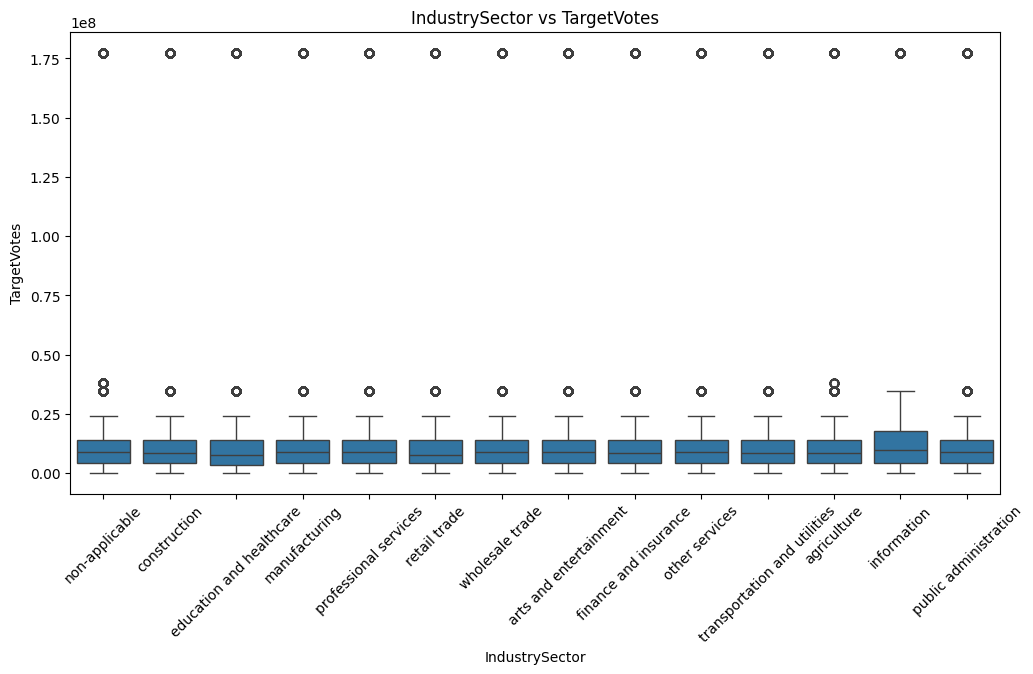

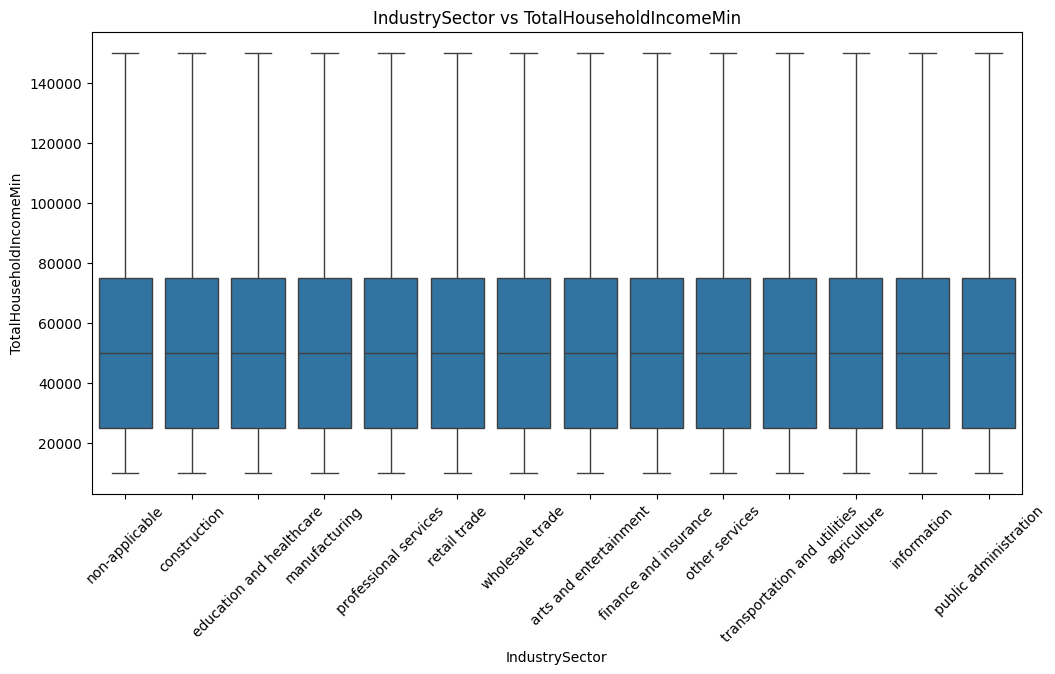

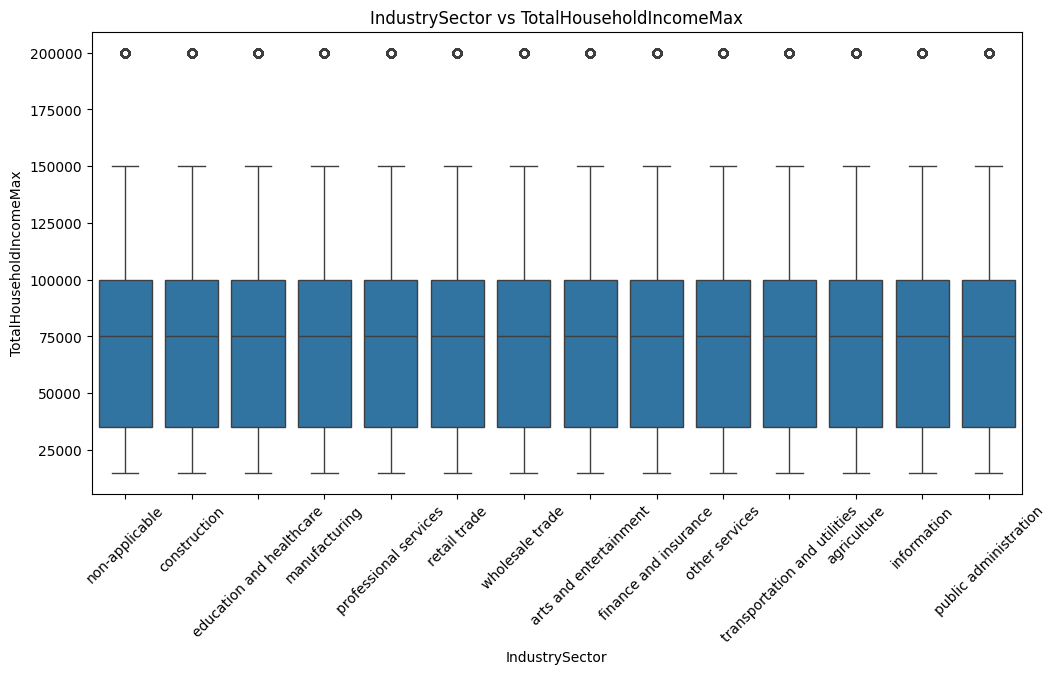

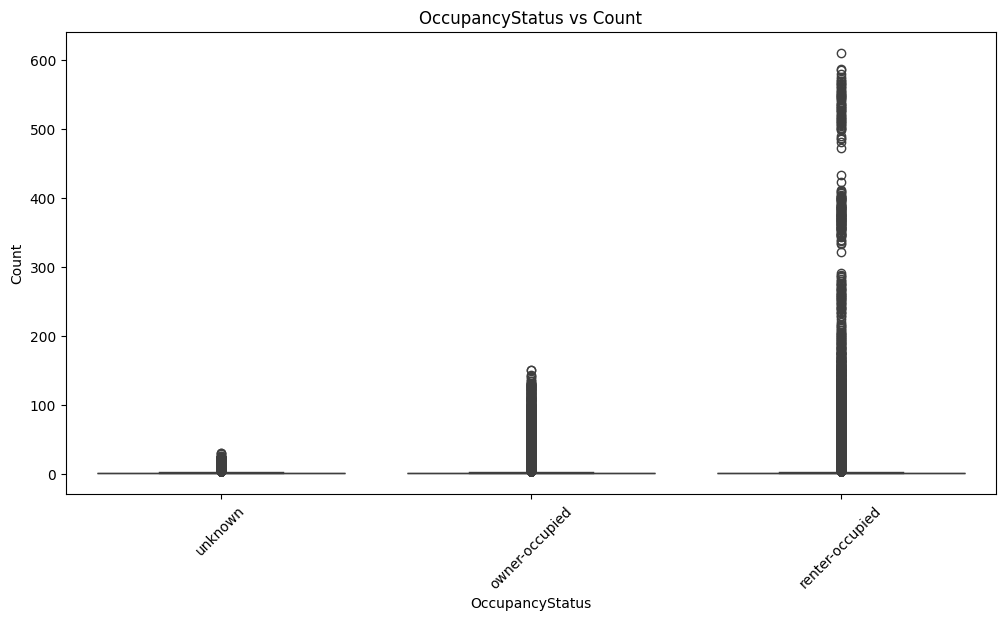

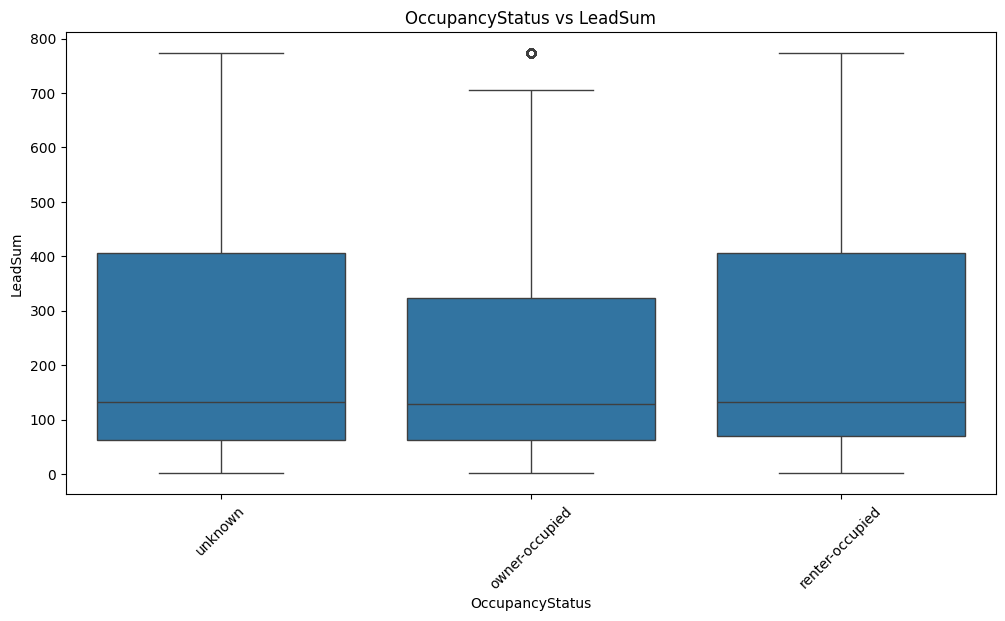

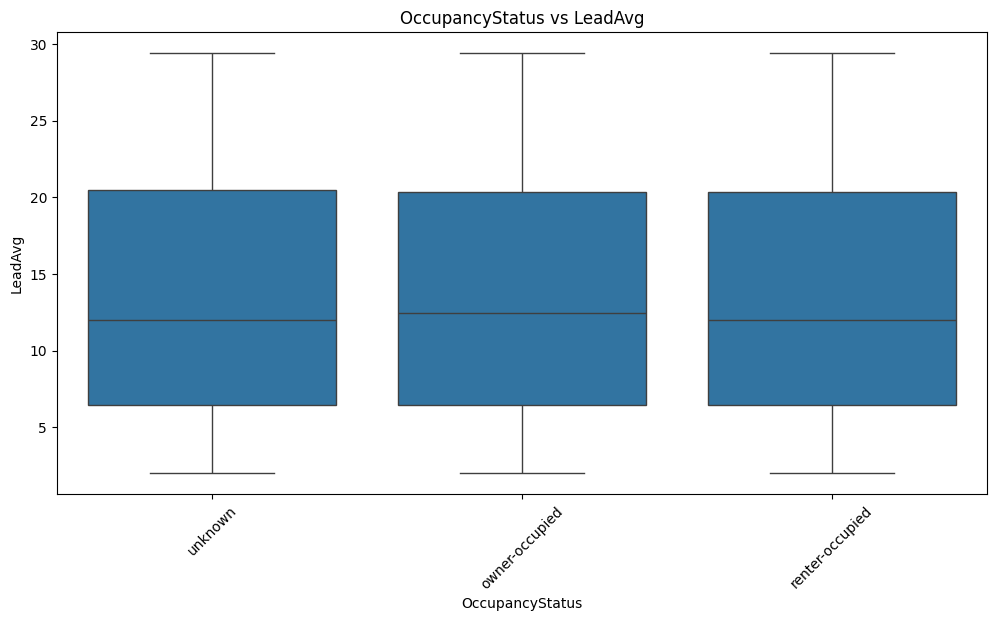

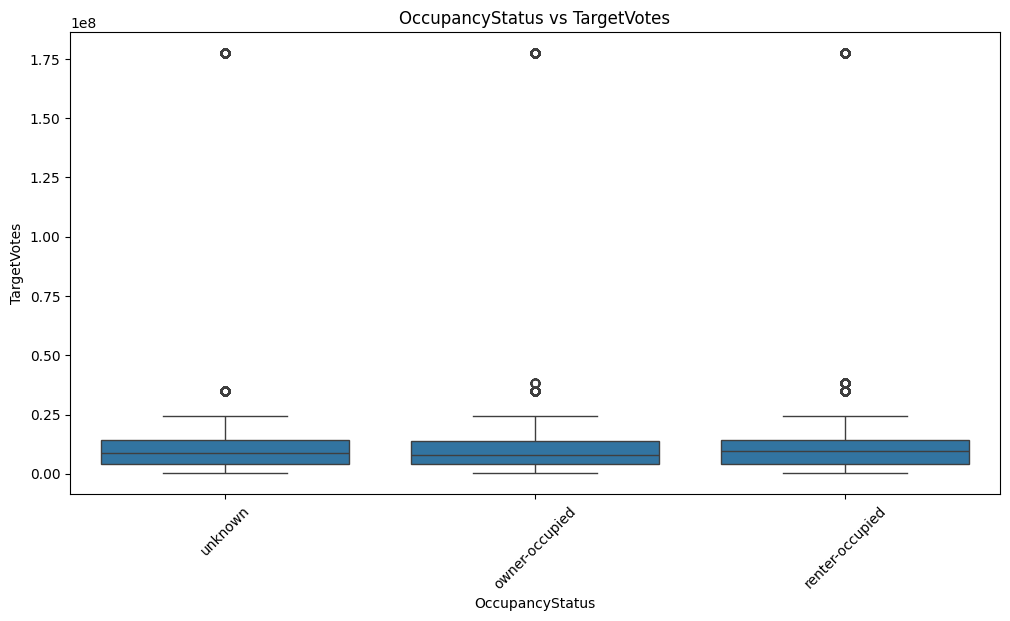

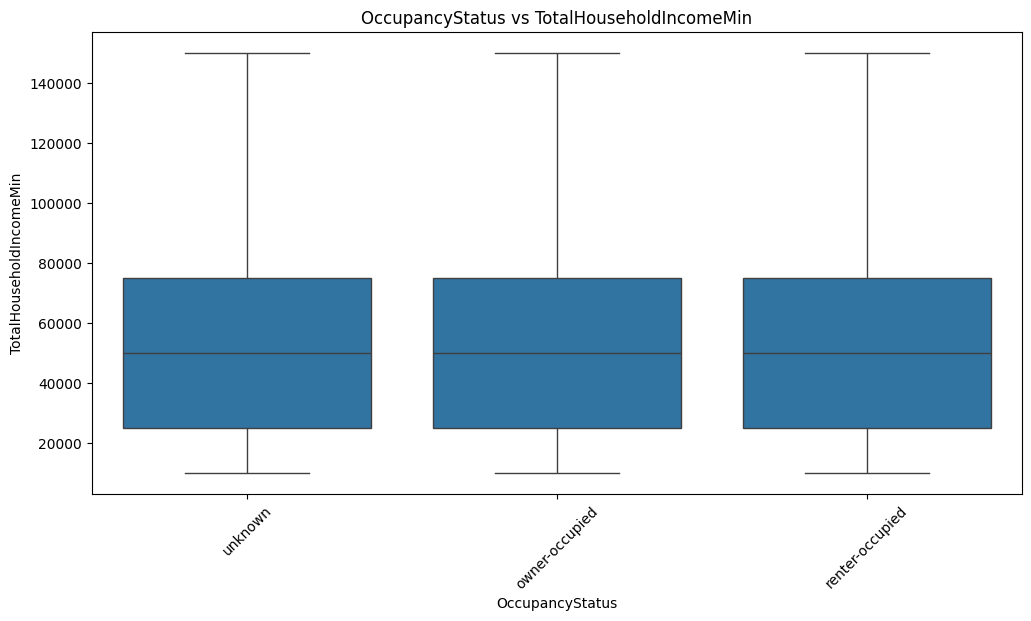

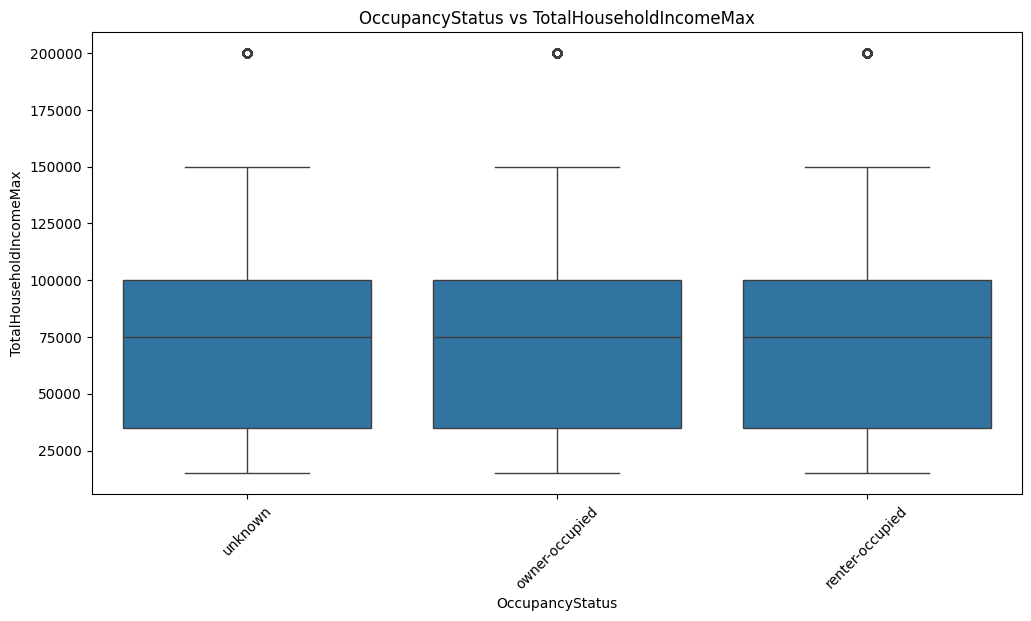

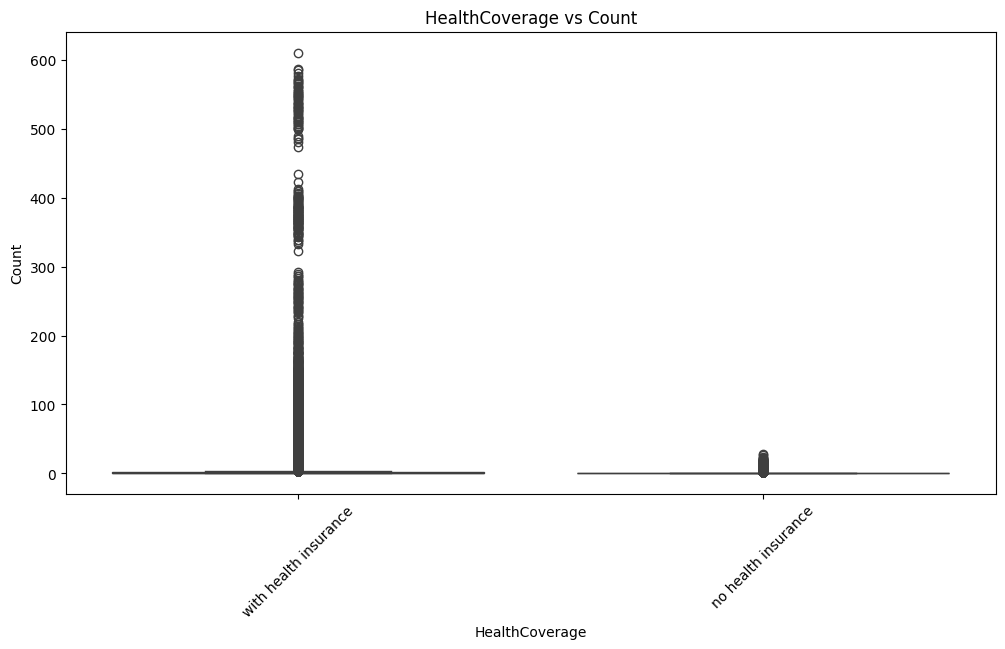

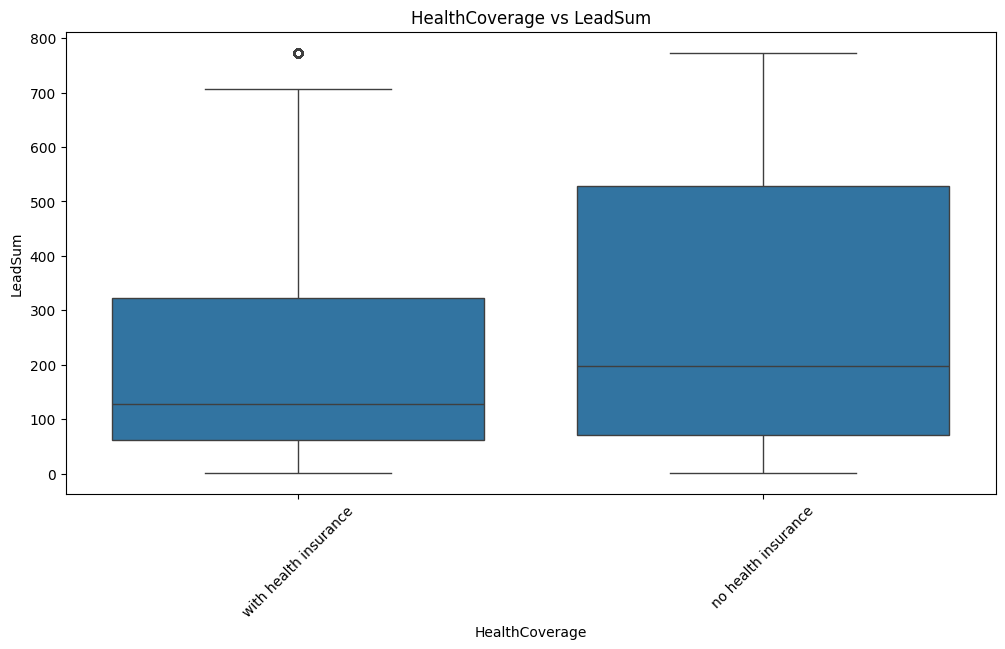

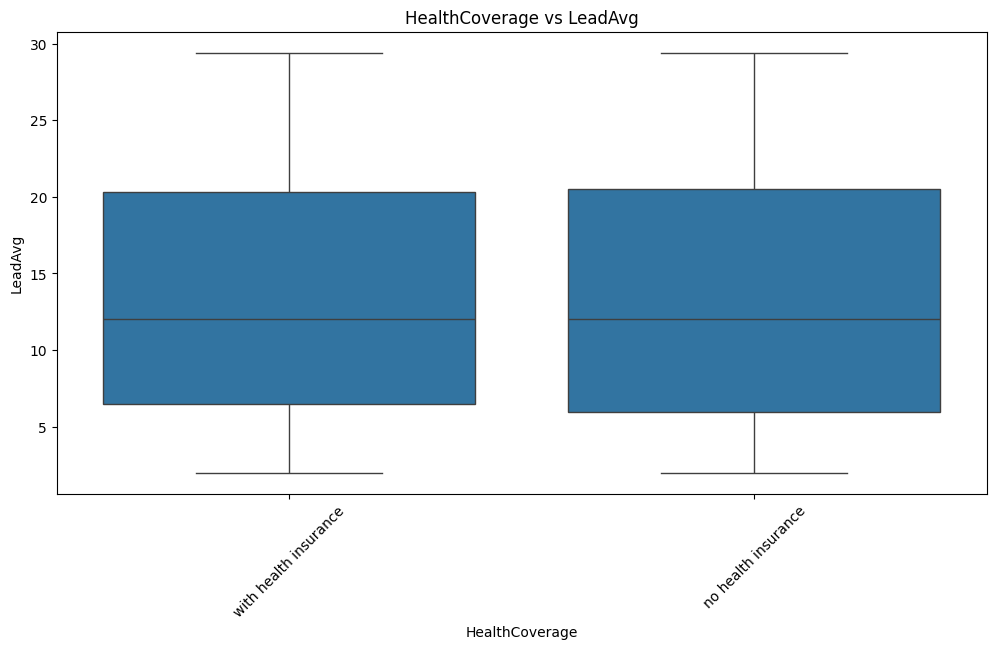

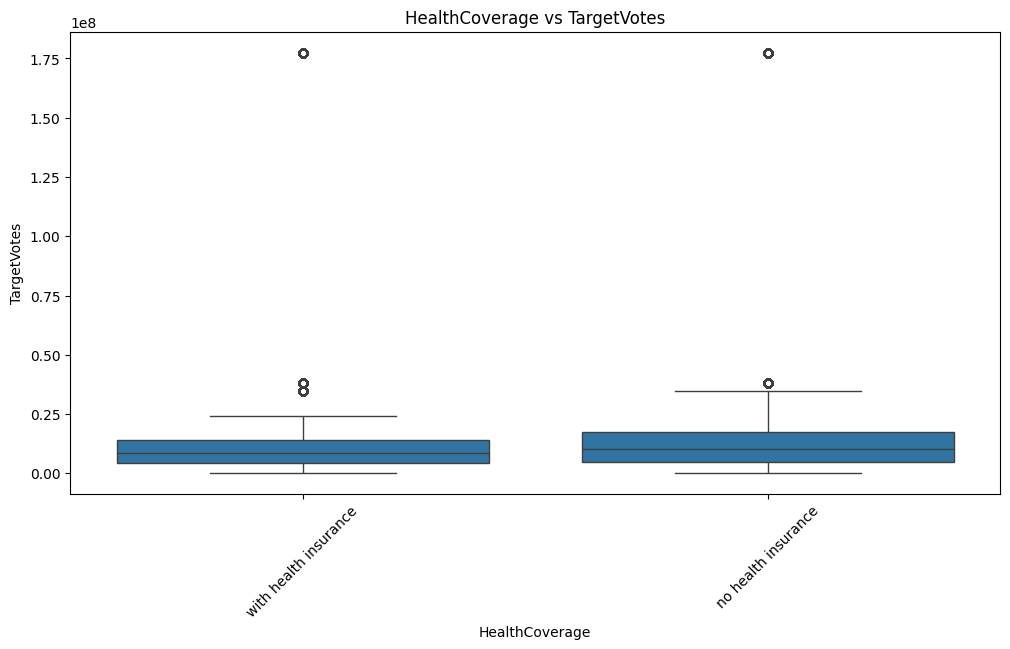

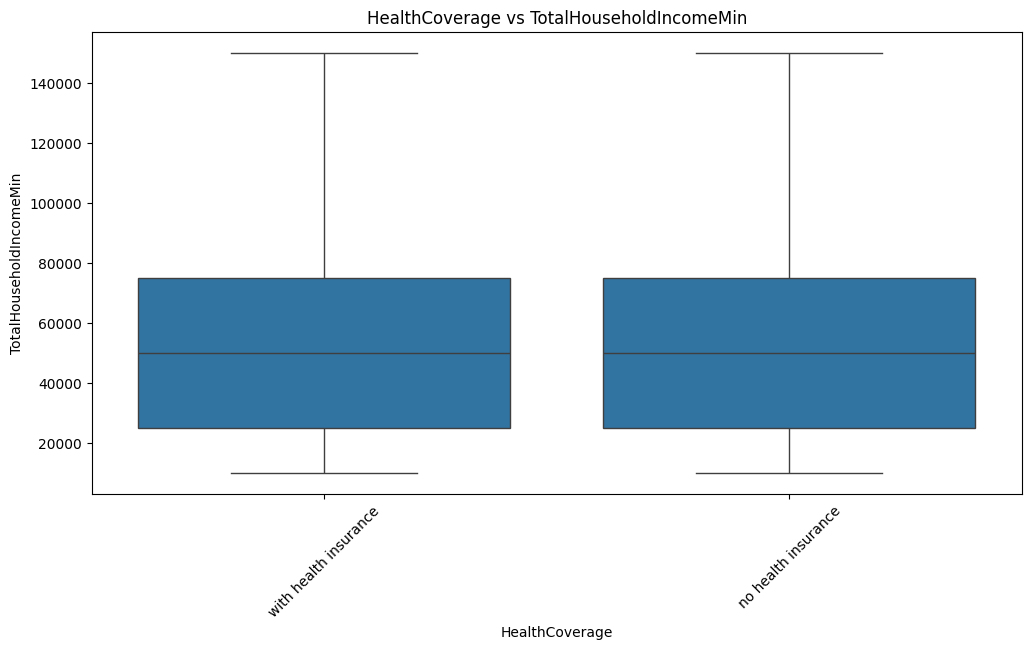

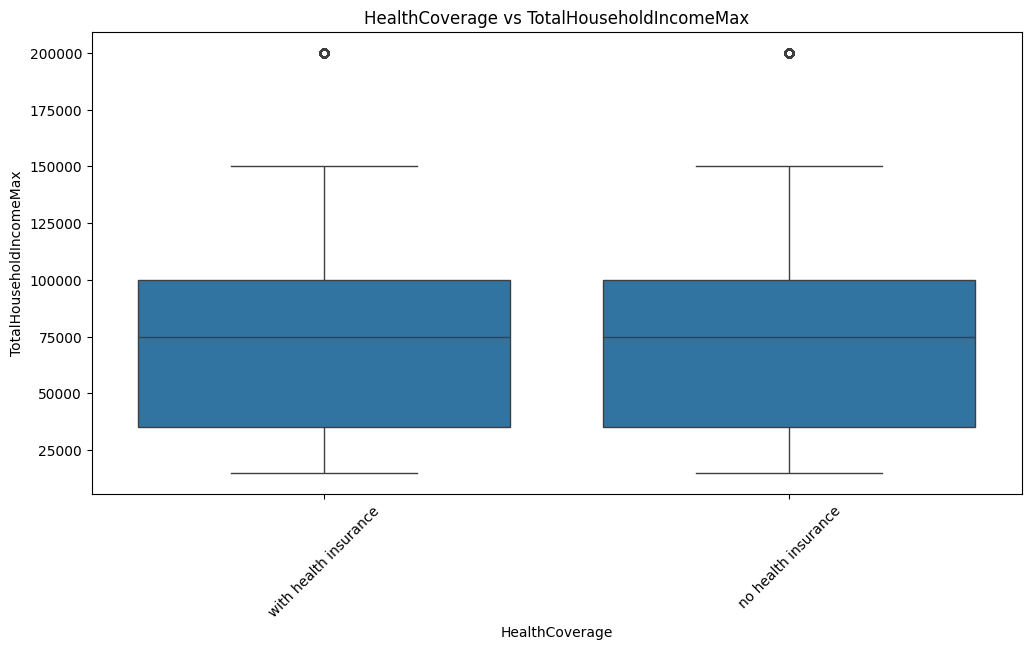

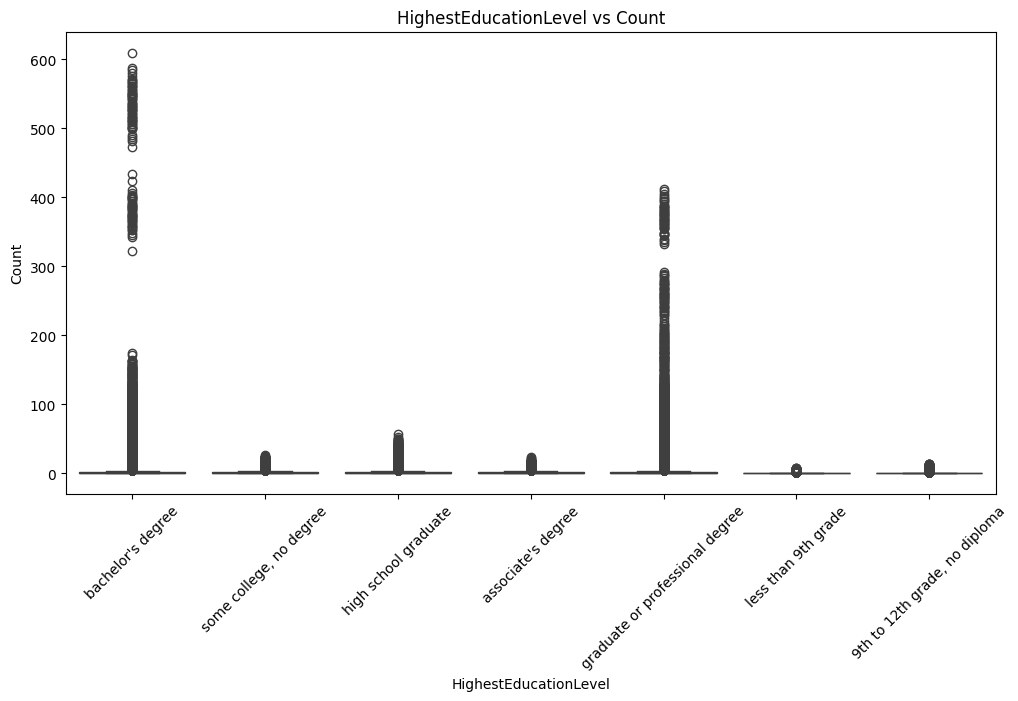

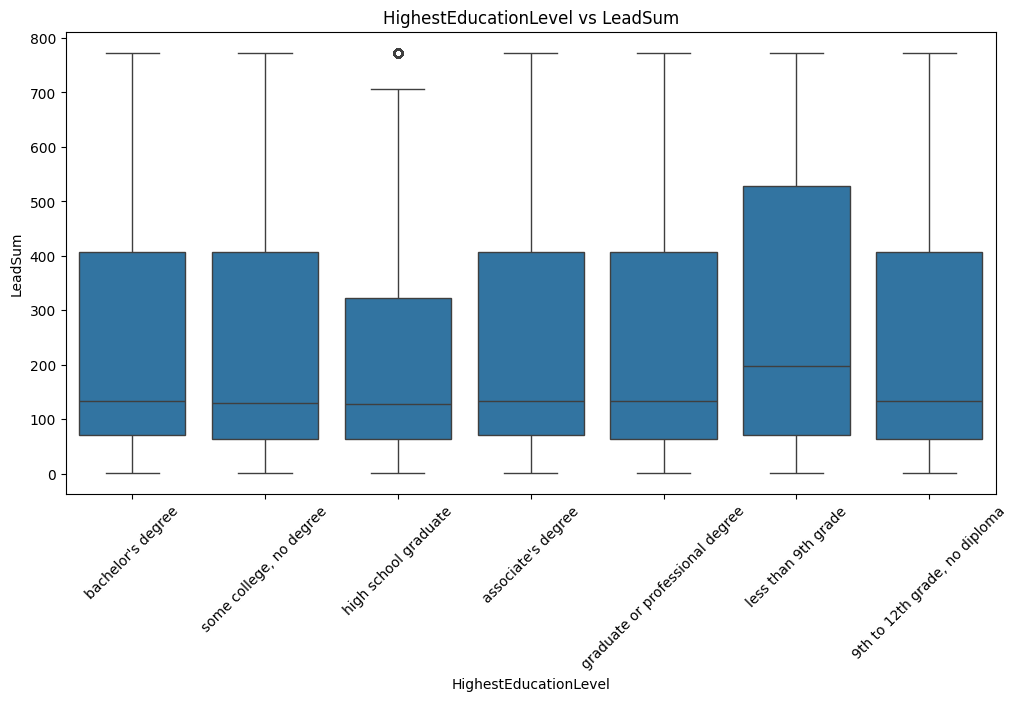

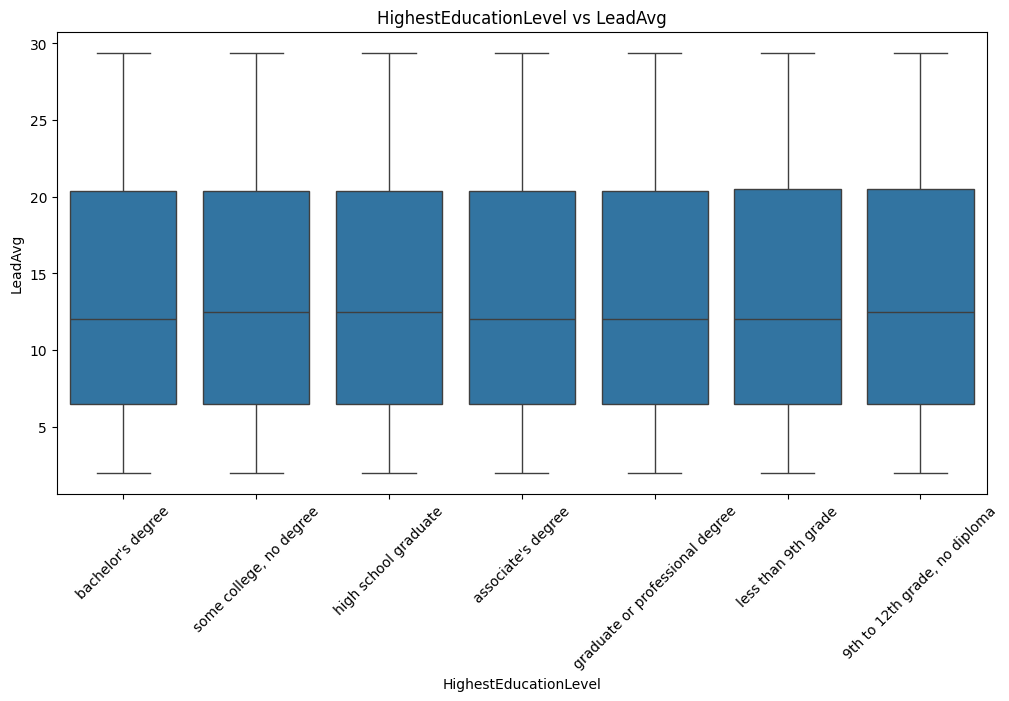

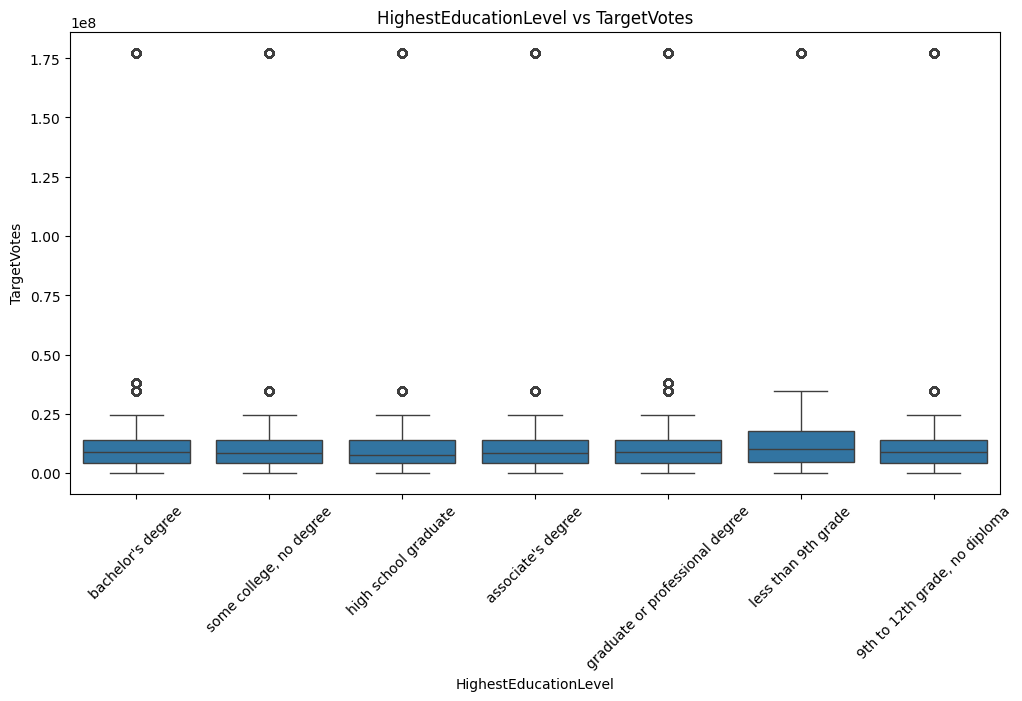

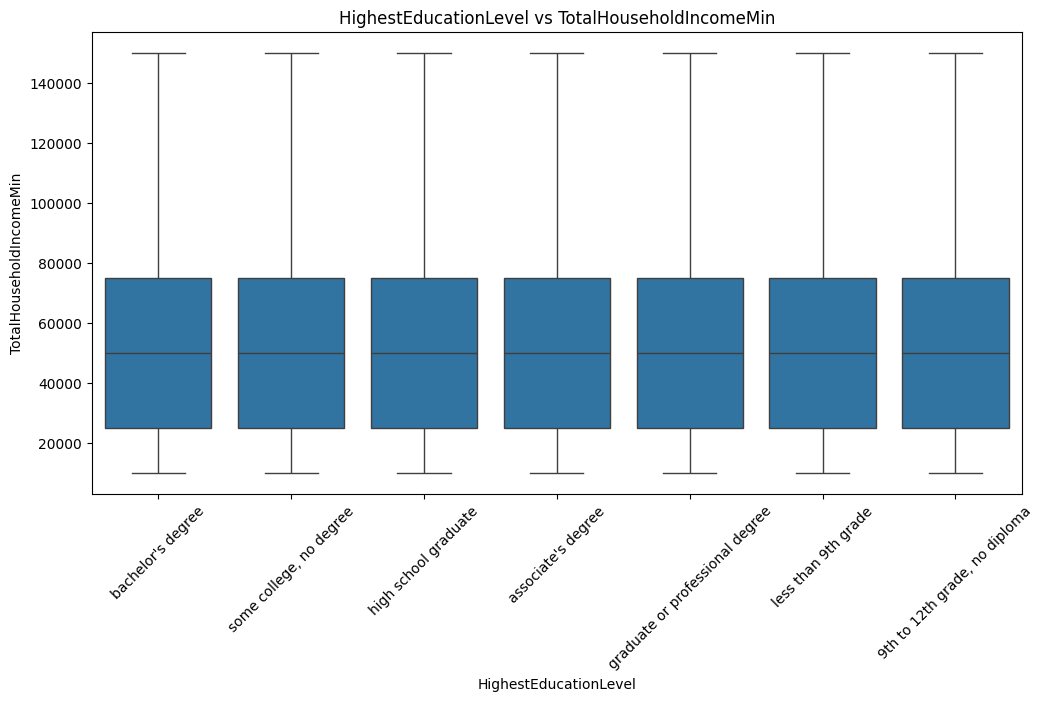

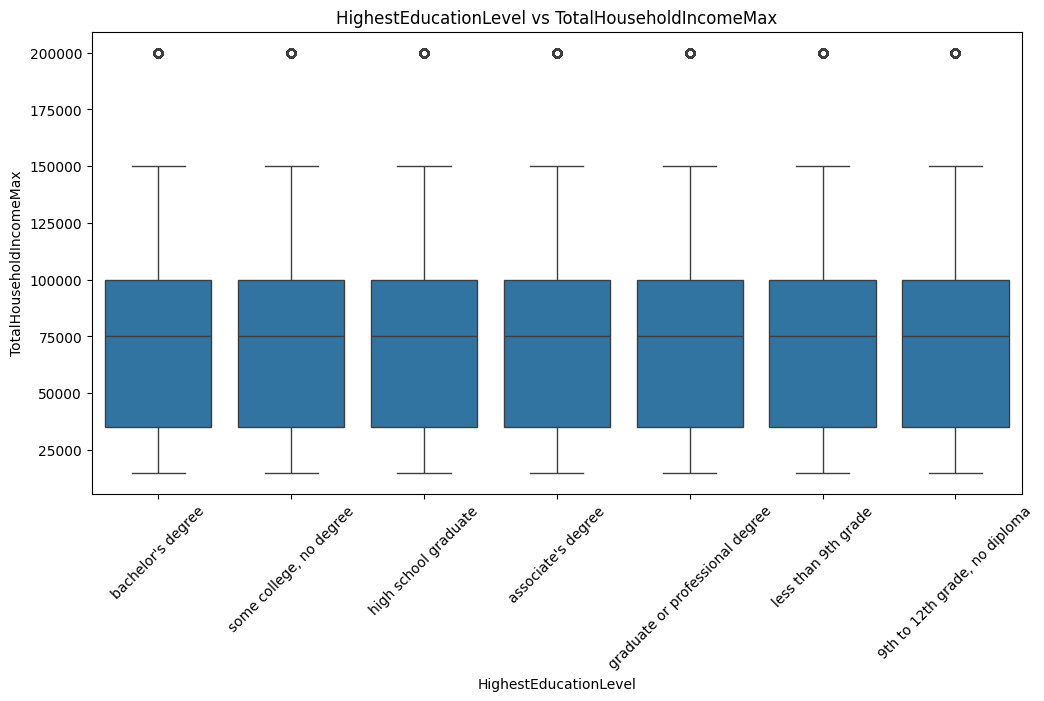

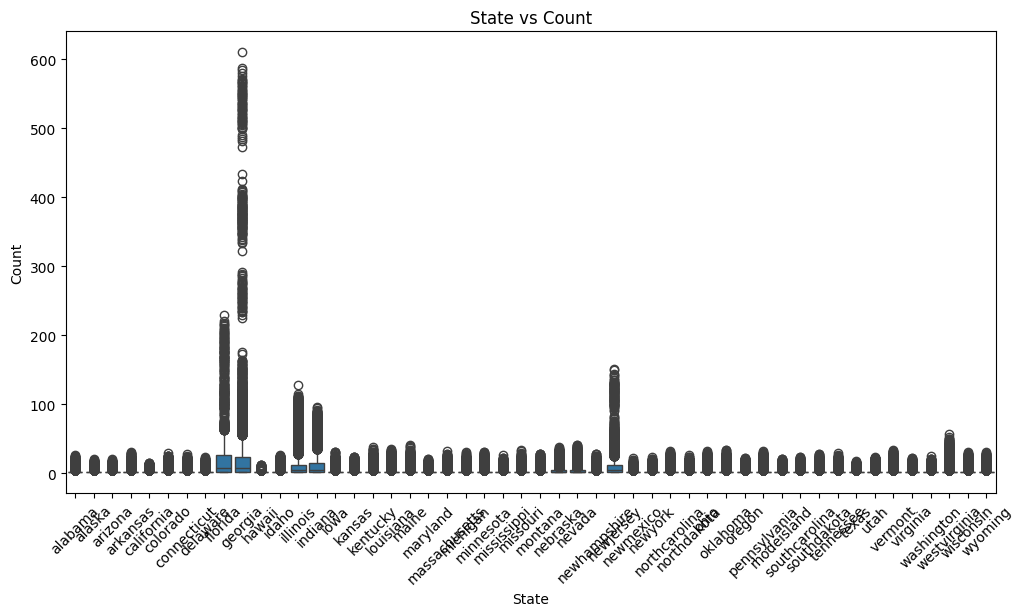

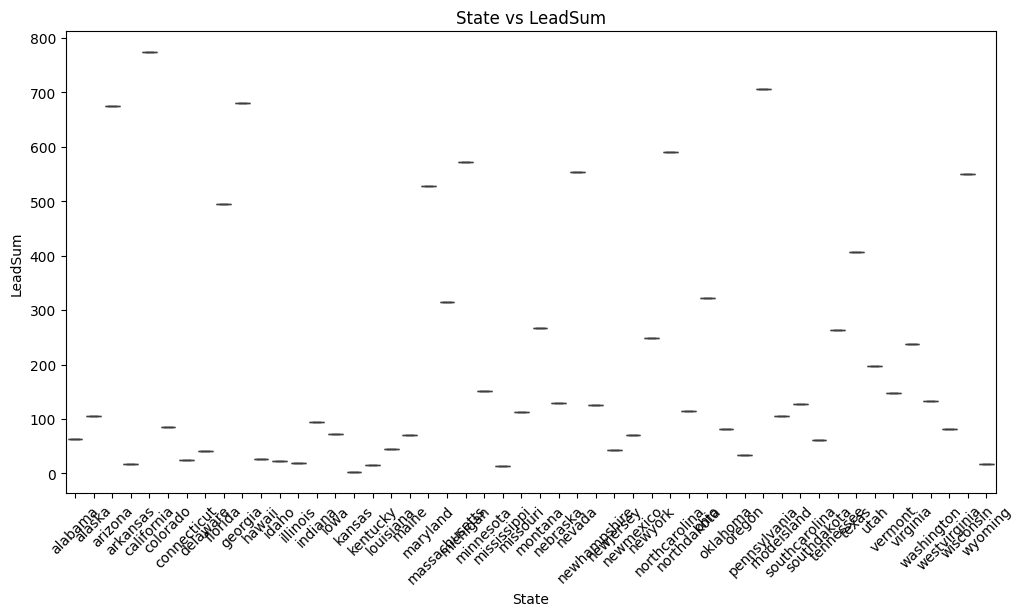

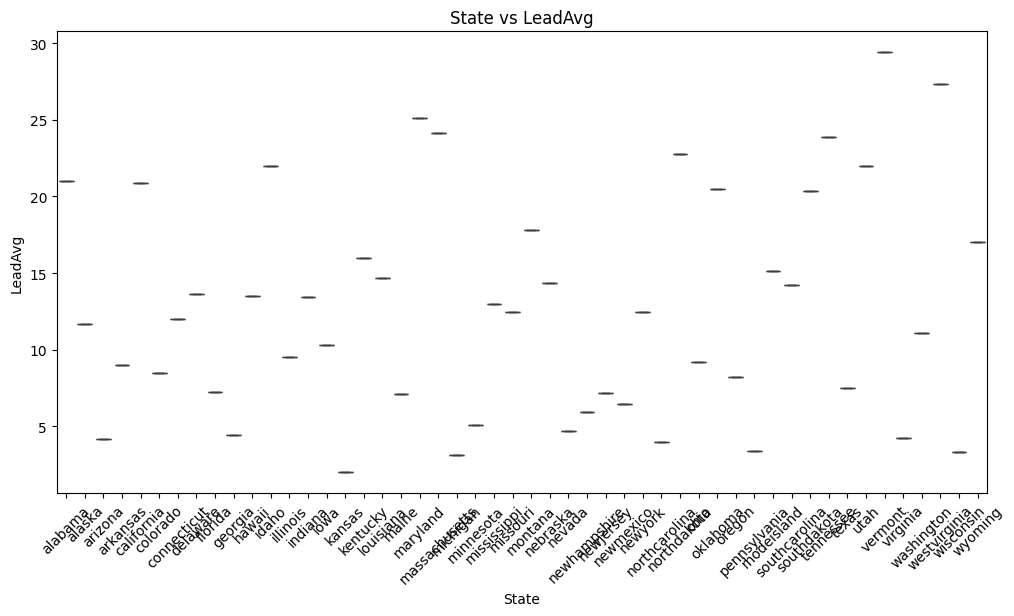

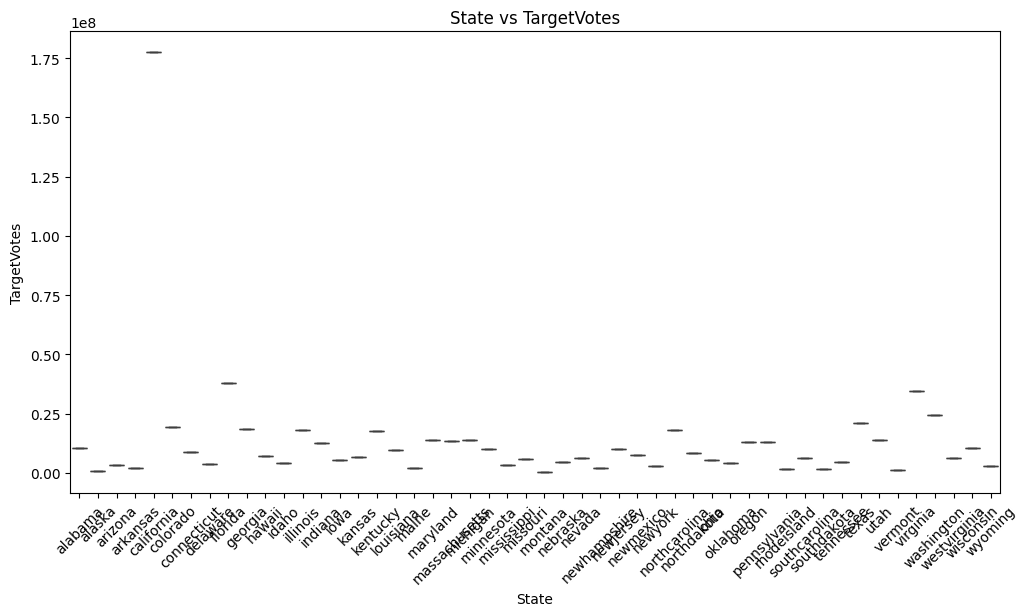

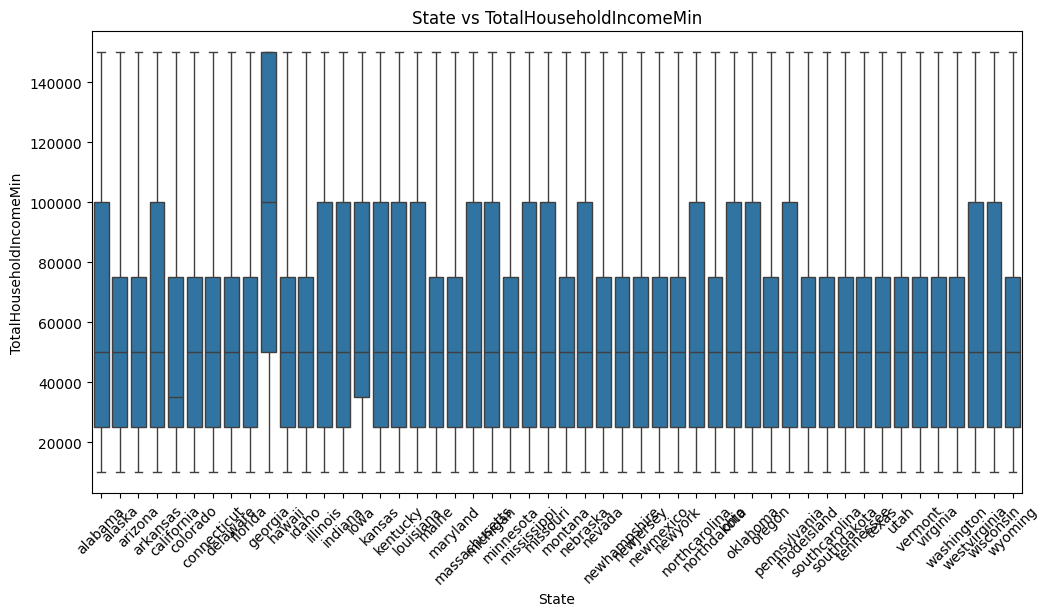

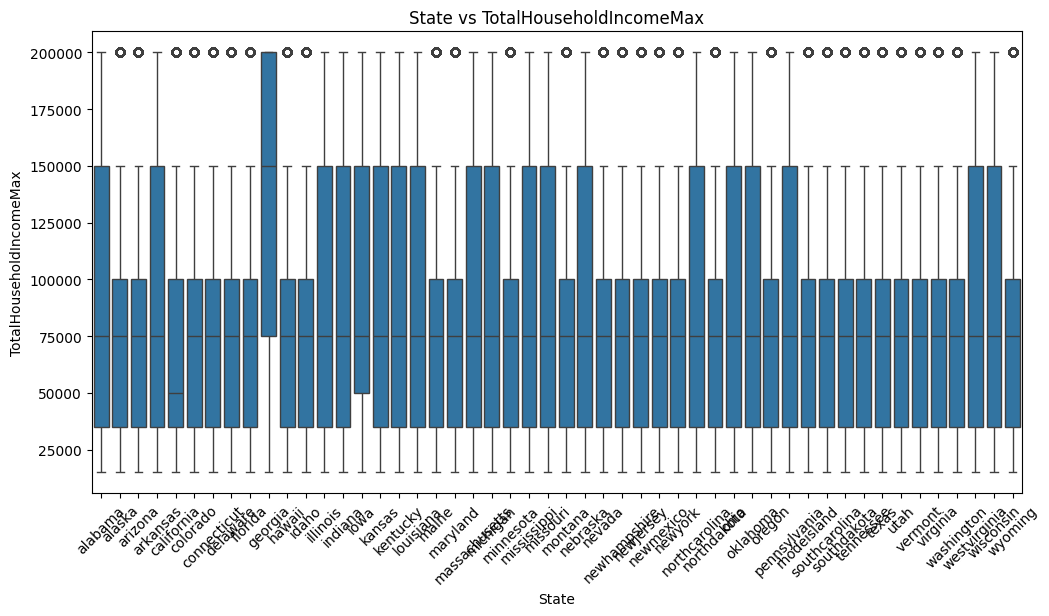

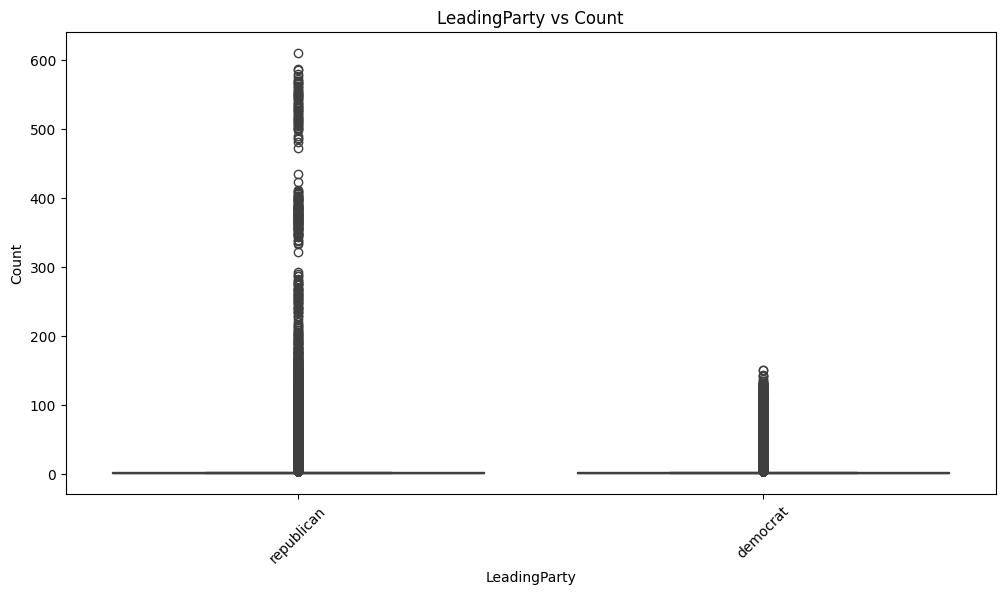

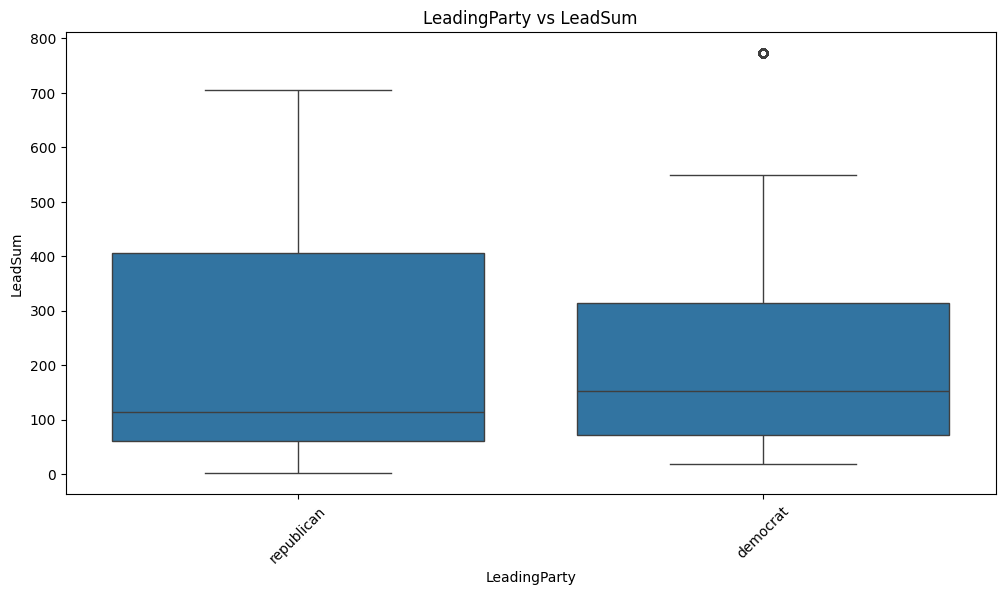

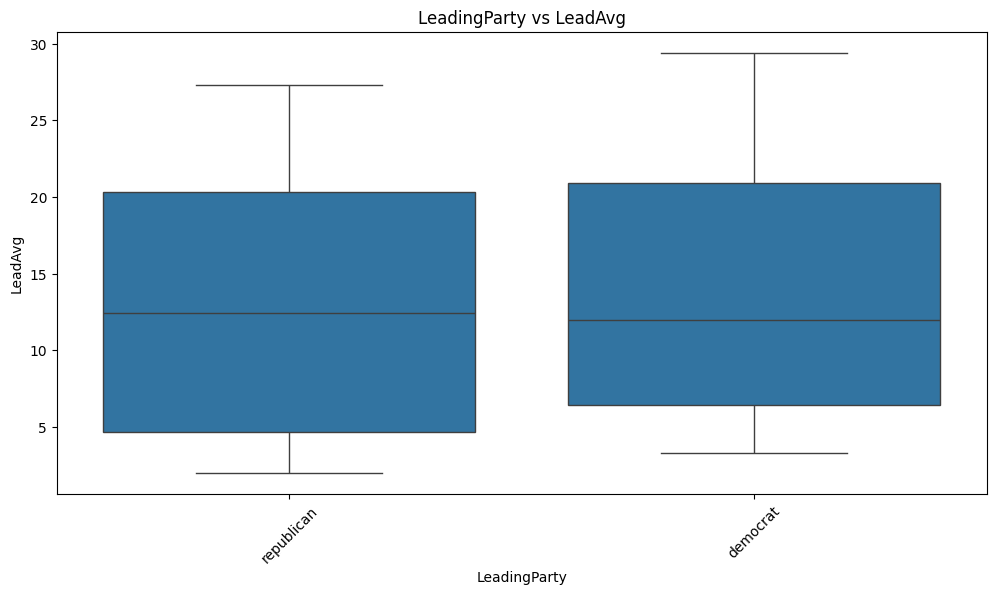

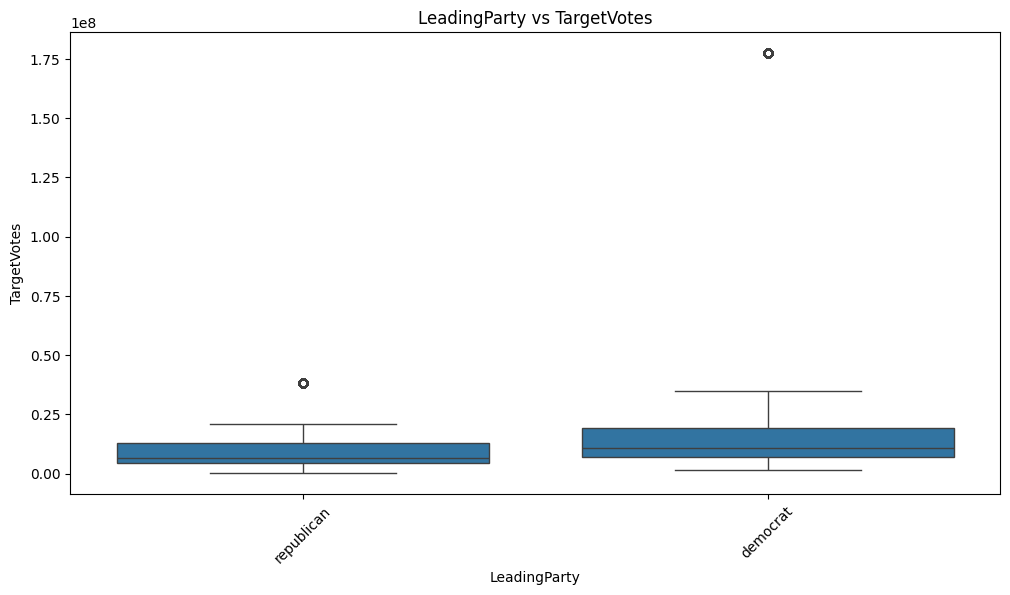

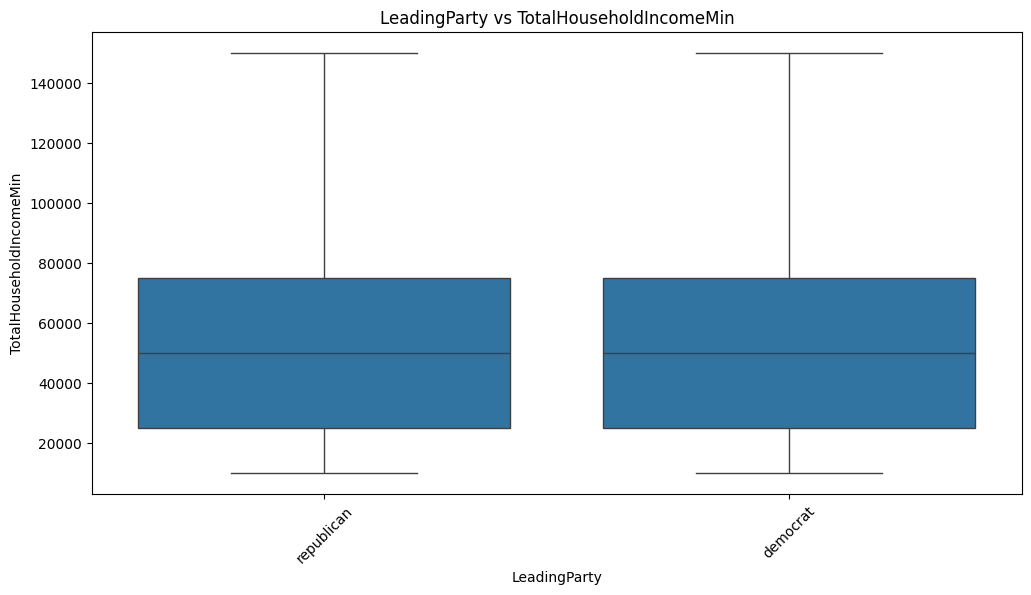

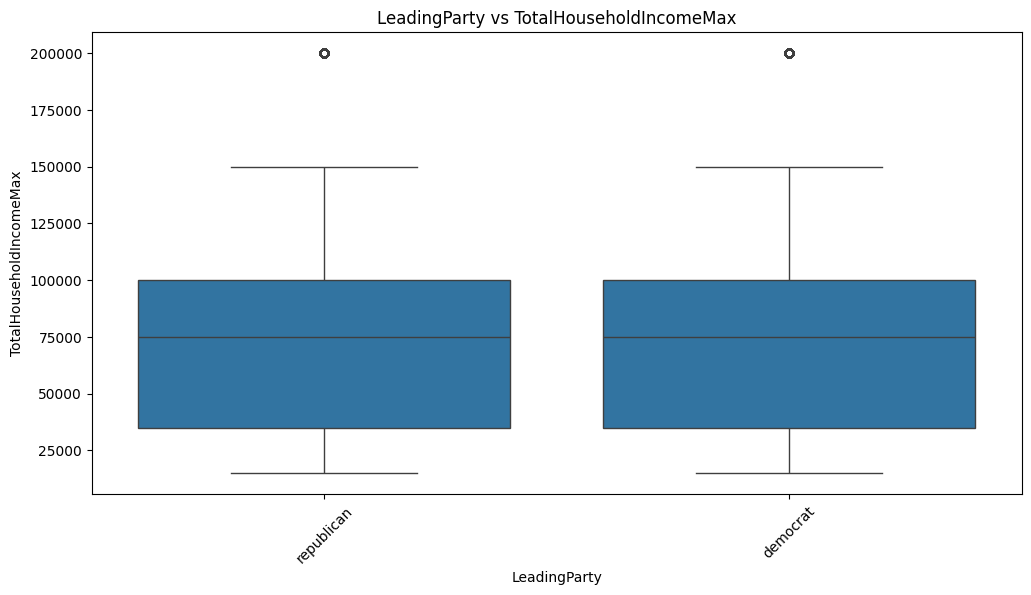

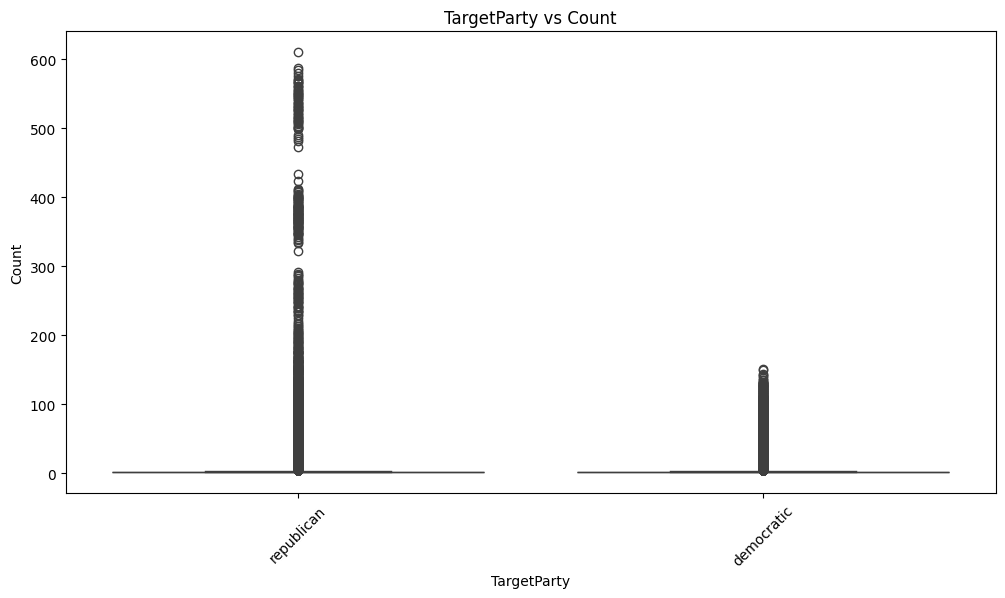

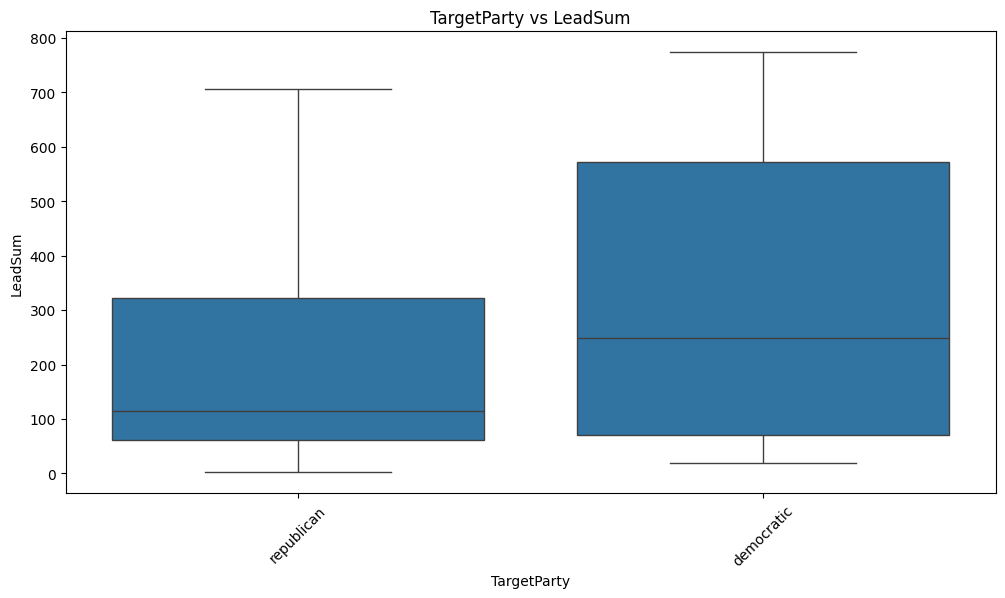

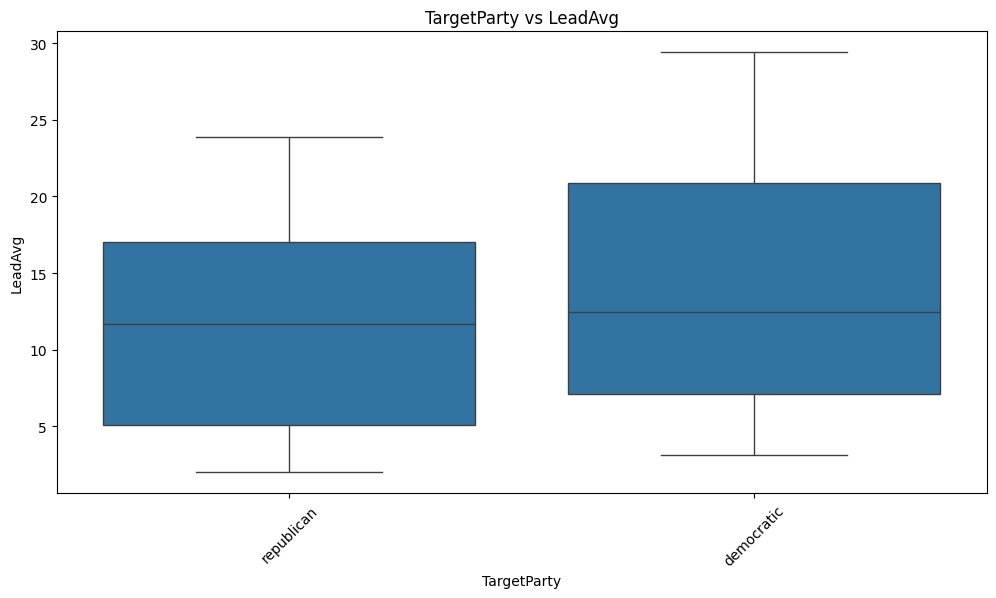

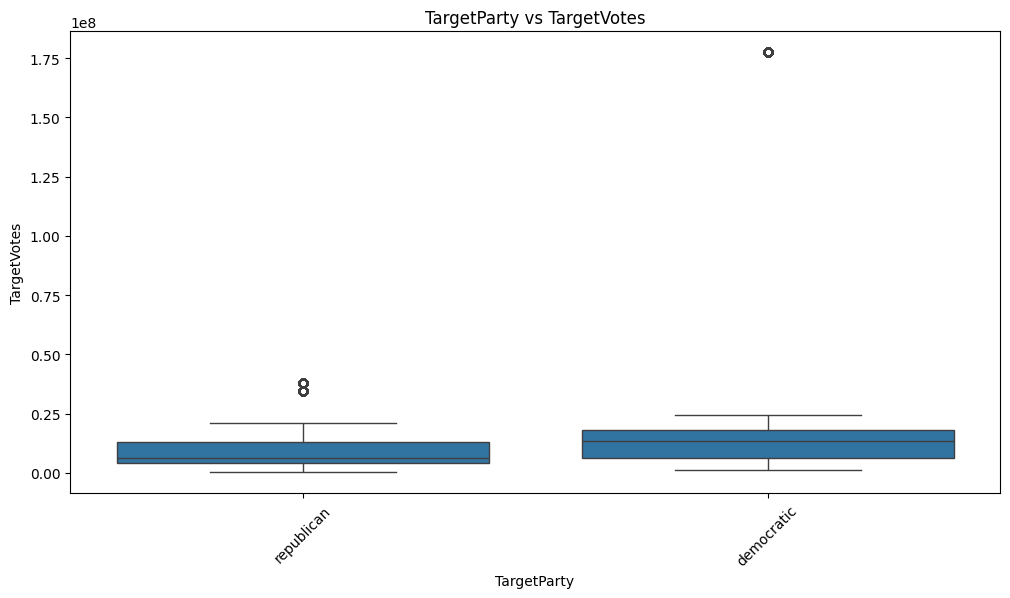

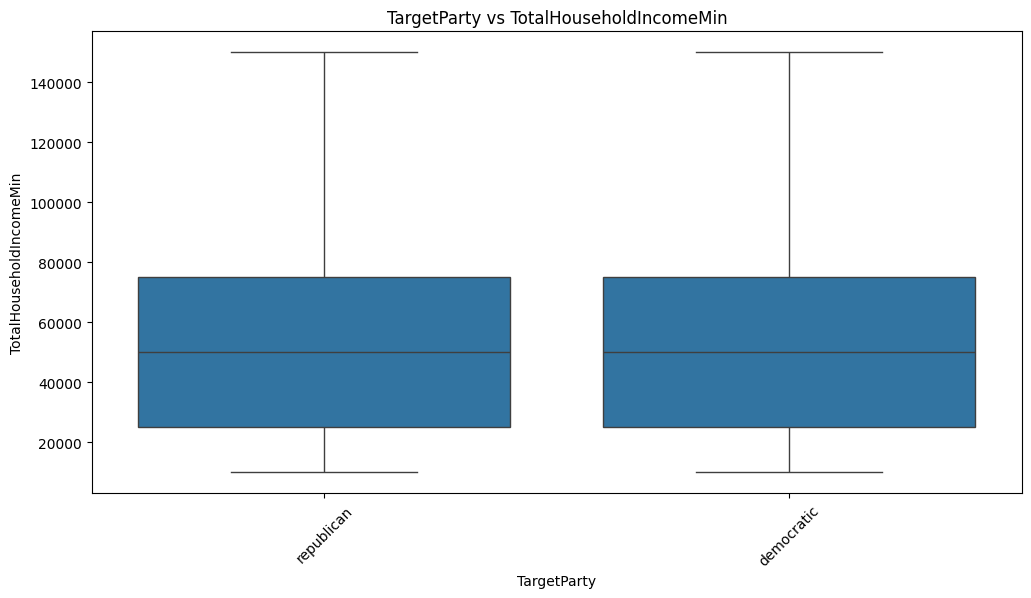

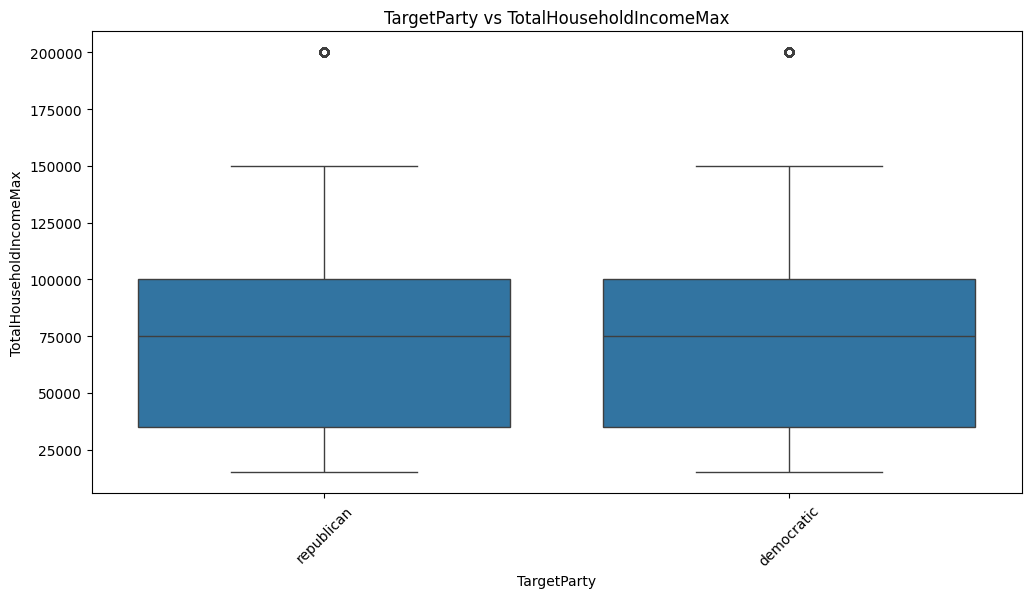

In [60]:
# Examine relationships between pairs of variables
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

for cat_col in text_columns:
    for num_col in numeric_columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=cat_col, y=num_col, data=df)
        plt.title(f'{cat_col} vs {num_col}')
        plt.xticks(rotation=45)
        plt.show()

In [61]:
# Chi-square test for categorical variables
for col in categorical_cols:
    crosstab = pd.crosstab(df[col], df['LeadingParty'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi-Square Test for {col} and LeadingParty:")
    print(f"Chi2 Stat: {chi2}, p-value: {p}")

Chi-Square Test for Gender and LeadingParty:
Chi2 Stat: 23.6446682598287, p-value: 1.1586648921024924e-06
Chi-Square Test for Race and LeadingParty:
Chi2 Stat: 15645.239849055251, p-value: 0.0
Chi-Square Test for VeteranStatus and LeadingParty:
Chi2 Stat: 704.1852346343594, p-value: 3.6779110829172166e-155
Chi-Square Test for DisabilityStatus and LeadingParty:
Chi2 Stat: 543.4228084782815, p-value: 3.39478331669882e-120
Chi-Square Test for EmploymentStatus and LeadingParty:
Chi2 Stat: 756.5293626386974, p-value: 1.1578760947185184e-163
Chi-Square Test for IndustrySector and LeadingParty:
Chi2 Stat: 3468.9576342917876, p-value: 0.0
Chi-Square Test for State and LeadingParty:
Chi2 Stat: 2937315.0, p-value: 0.0
Chi-Square Test for LeadingParty and LeadingParty:
Chi2 Stat: 2937310.8810321395, p-value: 0.0


### Multivariate Analysis

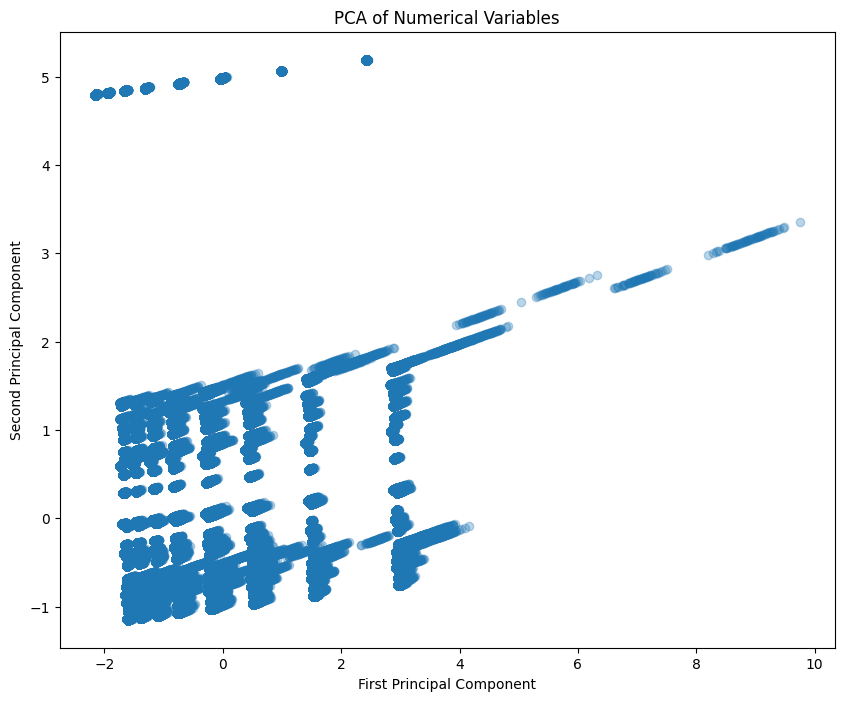

Explained variance ratio: [0.33401501 0.24855312]


In [62]:
# Perform dimensionality reduction

# Remove rows with NaN values in numeric columns
df_clean = df.dropna(subset=numeric_columns)

# Perform dimensionality reduction
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean[numeric_columns])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Visualize PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.3)
plt.title('PCA of Numerical Variables')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Feature Engineering

In [63]:
# Create new features
df['IncomeRange'] = df['TotalHouseholdIncomeMax'] - df['TotalHouseholdIncomeMin']
df['LeadRatio'] = df['LeadSum'] / df['TargetVotes']

In [64]:
df.head() # Show the head of the dataframe

Gender                           Race VeteranStatus    DisabilityStatus  \
0  female  american indian/alaska native   not veteran     with disability   
1  female  american indian/alaska native   not veteran     with disability   
2  female  american indian/alaska native   not veteran  without disability   
3  female  american indian/alaska native   not veteran  without disability   
4  female  american indian/alaska native   not veteran  without disability   

     EmploymentStatus            IndustrySector OccupancyStatus  \
0  not in labor force            non-applicable         unknown   
1  not in labor force            non-applicable         unknown   
2            employed              construction  owner-occupied   
3            employed  education and healthcare  owner-occupied   
4            employed  education and healthcare  owner-occupied   

          HealthCoverage    HighestEducationLevel  Count    State  \
0  with health insurance        bachelor's degree      1  alabama   
1  with health insurance  some college, no degree      1  alabama   
2  with health insurance     high school graduate      1  alabama   
3  with health insurance  some college, no degree      1  alabama   
4  with health insurance  some college, no degree      1  alabama   

  LeadingParty  LeadSum  LeadAvg TargetParty  TargetVotes  \
0   republican       63     21.0  republican   10680498.0   
1   republican       63     21.0  republican   10680498.0   
2   republican       63     21.0  republican   10680498.0   
3   republican       63     21.0  republican   10680498.0   
4   republican       63     21.0  republican   10680498.0   

   TotalHouseholdIncomeMin  TotalHouseholdIncomeMax  IncomeRange  LeadRatio  
0                 100000.0                 149999.0      49999.0   0.000006  
1                      NaN                      NaN          NaN   0.000006  
2                  25000.0                  34999.0       9999.0   0.000006  
3                  35000.0                  49999.0      14999.0   0.000006  
4                  75000.0                  99999.0      24999.0   0.000006

In [65]:
# Import necessary libraries
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical variables
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = onehot.fit_transform(df[categorical_cols])

# Use get_feature_names_out instead of get_feature_names
encoded_col_names = onehot.get_feature_names_out(categorical_cols)

# Create a new dataframe with encoded columns
encoded_df = pd.DataFrame(encoded_cols, columns=encoded_col_names)

# Append encoded columns to the original dataframe
df = pd.concat([df, encoded_df], axis=1)

# Drop original categorical columns
df = df.drop(columns=categorical_cols)

In [66]:
# Create interaction terms
df['LeadSum_TargetVotes'] = df['LeadSum'] * df['TargetVotes']
df['LeadAvg_IncomeRange'] = df['LeadAvg'] * df['IncomeRange']

In [67]:
print(df.columns) # Check the columns

Index(['OccupancyStatus', 'HealthCoverage', 'HighestEducationLevel', 'Count',
       'LeadSum', 'LeadAvg', 'TargetParty', 'TargetVotes',
       'TotalHouseholdIncomeMin', 'TotalHouseholdIncomeMax', 'IncomeRange',
       'LeadRatio', 'Gender_female', 'Gender_male',
       'Race_american indian/alaska native', 'Race_asian', 'Race_black',
       'Race_native hawaiian/other pacific islander', 'Race_some other race',
       'Race_two or more races', 'Race_white', 'VeteranStatus_not veteran',
       'VeteranStatus_veteran', 'DisabilityStatus_with disability',
       'DisabilityStatus_without disability', 'EmploymentStatus_armed forces',
       'EmploymentStatus_employed', 'EmploymentStatus_not in labor force',
       'EmploymentStatus_unemployed', 'IndustrySector_agriculture',
       'IndustrySector_arts and entertainment', 'IndustrySector_construction',
       'IndustrySector_education and healthcare',
       'IndustrySector_finance and insurance', 'IndustrySector_information',
       'Indu

In [68]:
df.head() # Show the head of the dataframe

OccupancyStatus         HealthCoverage    HighestEducationLevel  Count  \
0         unknown  with health insurance        bachelor's degree    1.0   
1         unknown  with health insurance  some college, no degree    1.0   
2  owner-occupied  with health insurance     high school graduate    1.0   
3  owner-occupied  with health insurance  some college, no degree    1.0   
4  owner-occupied  with health insurance  some college, no degree    1.0   

   LeadSum  LeadAvg TargetParty  TargetVotes  TotalHouseholdIncomeMin  \
0     63.0     21.0  republican   10680498.0                 100000.0   
1     63.0     21.0  republican   10680498.0                      NaN   
2     63.0     21.0  republican   10680498.0                  25000.0   
3     63.0     21.0  republican   10680498.0                  35000.0   
4     63.0     21.0  republican   10680498.0                  75000.0   

   TotalHouseholdIncomeMax  ...  State_vermont  State_virginia  \
0                 149999.0  ...            0.0             0.0   
1                      NaN  ...            0.0             0.0   
2                  34999.0  ...            0.0             0.0   
3                  49999.0  ...            0.0             0.0   
4                  99999.0  ...            0.0             0.0   

   State_washington  State_westvirginia  State_wisconsin  State_wyoming  \
0               0.0                 0.0              0.0            0.0   
1               0.0                 0.0              0.0            0.0   
2               0.0                 0.0              0.0            0.0   
3               0.0                 0.0              0.0            0.0   
4               0.0                 0.0              0.0            0.0   

   LeadingParty_democrat  LeadingParty_republican  LeadSum_TargetVotes  \
0                    0.0                      1.0          672871374.0   
1                    0.0                      1.0          672871374.0   
2                    0.0                      1.0          672871374.0   
3                    0.0                      1.0          672871374.0   
4                    0.0                      1.0          672871374.0   

   LeadAvg_IncomeRange  
0            1049979.0  
1                  NaN  
2             209979.0  
3             314979.0  
4             524979.0  

[5 rows x 97 columns]

In [69]:
'''
# Feature selection
X = df.drop(['TargetParty'], axis=1)
y = df['TargetParty']
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)
'''

'\n# Feature selection\nX = df.drop([\'TargetParty\'], axis=1)\ny = df[\'TargetParty\']\nselector = SelectKBest(score_func=f_classif, k=10)\nX_new = selector.fit_transform(X, y)\nselected_features = X.columns[selector.get_support()].tolist()\nprint("Selected features:", selected_features)\n'

# Normalization and Data Processing

In [70]:
# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = StandardScaler()
df[numeric_cols] = minmax_scaler.fit_transform(df[numeric_cols])

In [71]:
df.shape # Check the shape of the dataframe

(5679446, 97)

In [72]:
# Ensure all data is numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [73]:
# Drop any remaining non-numeric columns
# df = df.select_dtypes(include=[np.number])

# Step 2 - Modelling (Cognify)

# Training and Test Split